Dataset
=========================================
Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions,
precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to  
the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is
publicly available in http://capitalbikeshare.com/system-data. We aggregated the data on two hourly and daily basis and then
extracted and added the corresponding weather and seasonal information. Weather information are extracted from http://www.freemeteo.com.


Dataset characteristics
=========================================
Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv

	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit :
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registere

# Importing Libraries and Dataset

In [ ]:
!pip install prophet
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 4.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from prophet import Prophet
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import shap

In [ ]:
# Connecting Google Drive to load/store datset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing datasets
day = pd.read_csv('/content/drive/MyDrive/Coursework/2023 Fall/Applied ML/AML Final Project/day.csv')
hour = pd.read_csv('/content/drive/MyDrive/Coursework/2023 Fall/Applied ML/AML Final Project/hour.csv')

# Pre-Processing

In [ ]:
# Dropping NaN values
day = day.dropna()
hour = hour.dropna()

# DataFrame after dropping NaNs
print("\nDay DataFrame after dropping NaNs:")
print(day.shape)

print("\nHour DataFrame after dropping NaNs:")
print(hour.shape)


Day DataFrame after dropping NaNs:
(731, 16)

Hour DataFrame after dropping NaNs:
(17379, 17)


In [ ]:
# Ensuring date/time data is in correct format
day['dteday'] = pd.to_datetime(day['dteday'])
hour['dteday'] = pd.to_datetime(hour['dteday'])

In [ ]:
# dropping irrelevant columns
# Dropping dteday since these are captured in derived features
day = day.drop(columns=['instant', 'dteday'])
hour = hour.drop(columns=['instant', 'dteday'])

In [ ]:
# X and y
# 1. Regression for cnt
# 2. Regression for casual
# 3. Regression for registered

# 1.
X1_day = day.drop(columns=['casual', 'registered', 'cnt'])
X1_hour = hour.drop(columns=['casual', 'registered', 'cnt'])

y1_day = day['cnt']
y1_hour = hour['cnt']

# 2.
X2_day = day.drop(columns=['casual', 'registered', 'cnt'])
X2_hour = hour.drop(columns=['casual', 'registered', 'cnt'])

y2_day = day['casual']
y2_hour = hour['casual']

# 3.
X3_day = day.drop(columns=['casual', 'registered', 'cnt'])
X3_hour = hour.drop(columns=['casual', 'registered', 'cnt'])

y3_day = day['registered']
y3_hour = hour['registered']

In [ ]:
# Splitting data
# 1. Regression for cnt
X1_train_day, X1_test_day, y1_train_day, y1_test_day = train_test_split(X1_day, y1_day, test_size=0.20, random_state=42)
X1_train_hour, X1_test_hour, y1_train_hour, y1_test_hour = train_test_split(X1_hour, y1_hour, test_size=0.20, random_state=42)

# 2. Regression for casual
X2_train_day, X2_test_day, y2_train_day, y2_test_day = train_test_split(X2_day, y2_day, test_size=0.20, random_state=42)
X2_train_hour, X2_test_hour, y2_train_hour, y2_test_hour = train_test_split(X2_hour, y2_hour, test_size=0.20, random_state=42)

# 3. Regression for registered
X3_train_day, X3_test_day, y3_train_day, y3_test_day = train_test_split(X3_day, y3_day, test_size=0.20, random_state=42)
X3_train_hour, X3_test_hour, y3_train_hour, y3_test_hour = train_test_split(X3_hour, y3_hour, test_size=0.20, random_state=42)

# Linear Regression

Model Training and Testing:

In [ ]:
# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

model = LinearRegression()

MSEs = []
r2s = []

model_day_total = LinearRegression()

# train day total cnt
mse_1_day = -cross_val_score(model_day_total, X1_train_day, y1_train_day, cv=tscv, scoring='neg_mean_squared_error')
print('Average MSE for #1 (total count) for "day" df:', np.mean(mse_1_day))
r2_1_day = cross_val_score(model_day_total, X1_train_day, y1_train_day, cv=tscv, scoring='r2')
print('Average R2 for #1 (total count) for "day" df:', np.mean(r2_1_day))
print('\n')

# test day total cnt
model_day_total.fit(X1_train_day, y1_train_day)
y1_pred = model_day_total.predict(X1_test_day)
test_mse = mean_squared_error(y1_test_day, y1_pred)
print('Test MSE for #1 (total count) for "day" df:', test_mse)
test_r2 = r2_score(y1_test_day, y1_pred)
print('Test R2 for #1 (total count) for "day" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

model_hour_total = LinearRegression()

# train hour total cnt
mse_1_hour = -cross_val_score(model_hour_total, X1_train_hour, y1_train_hour, cv=tscv, scoring='neg_mean_squared_error')
print('Average MSE for #1 (total count) for "hour" df:', np.mean(mse_1_hour))
r2_1_hour = cross_val_score(model_hour_total, X1_train_hour, y1_train_hour, cv=tscv, scoring='r2')
print('Average R2 for #1 (total count) for "hour" df:', np.mean(r2_1_hour))
print('\n')

# test hour total cnt
model_hour_total.fit(X1_train_hour, y1_train_hour)
y1_pred = model_hour_total.predict(X1_test_hour)
test_mse = mean_squared_error(y1_test_hour, y1_pred)
print('Test MSE for #1 (total count) for "hour" df:', test_mse)
test_r2 = r2_score(y1_test_hour, y1_pred)
print('Test R2 for #1 (total count) for "hour" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

model_day_casual = LinearRegression()

# train day casual
mse_2_day = -cross_val_score(model_day_casual, X2_train_day, y2_train_day, cv=tscv, scoring='neg_mean_squared_error')
print('Average MSE for #2 (casuals only) for "day" df:', np.mean(mse_1_day))
r2_2_day = cross_val_score(model_day_casual, X2_train_day, y2_train_day, cv=tscv, scoring='r2')
print('Average R2 for #2 (casuals only) for "day" df:', np.mean(r2_2_day))
print('\n')

# test day casual
model_day_casual.fit(X2_train_day, y2_train_day)
y2_pred = model_day_casual.predict(X2_test_day)
test_mse = mean_squared_error(y2_test_day, y2_pred)
print('Test MSE for #2 (casuals only) for "day" df:', test_mse)
test_r2 = r2_score(y2_test_day, y2_pred)
print('Test R2 for #2 (casuals only) for "day" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

model_hour_casual = LinearRegression()

# train hour casual
mse_2_hour = -cross_val_score(model_hour_casual, X2_train_hour, y2_train_hour, cv=tscv, scoring='neg_mean_squared_error')
print('Average MSE for #2 (casuals only) for "hour" df:', np.mean(mse_2_hour))
r2_2_hour = cross_val_score(model_hour_casual, X2_train_hour, y2_train_hour, cv=tscv, scoring='r2')
print('Average R2 for #2 (casuals only) for "hour" df:', np.mean(r2_2_hour))
print('\n')

# test hour casual
model_hour_casual.fit(X2_train_hour, y2_train_hour)
y2_pred = model_hour_casual.predict(X2_test_hour)
test_mse = mean_squared_error(y2_test_hour, y2_pred)
print('Test MSE for #2 (casuals only) for "hour" df:', test_mse)
test_r2 = r2_score(y2_test_hour, y2_pred)
print('Test R2 for #2 (casuals only) for "hour" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

model_day_reg = LinearRegression()

# train day registered
mse_3_day = -cross_val_score(model_day_reg, X3_train_day, y3_train_day, cv=tscv, scoring='neg_mean_squared_error')
print('Average MSE for #3 (registered only) for "day" df:', np.mean(mse_3_day))
r2_3_day = cross_val_score(model_day_reg, X3_train_day, y3_train_day, cv=tscv, scoring='r2')
print('Average R2 for #3 (registered only) for "day" df:', np.mean(r2_3_day))
print('\n')

# test day registered
model_day_reg.fit(X3_train_day, y3_train_day)
y3_pred = model_day_reg.predict(X3_test_day)
test_mse = mean_squared_error(y3_test_day, y3_pred)
print('Test MSE for #3 (registered only) for "day" df:', test_mse)
test_r2 = r2_score(y3_test_day, y3_pred)
print('Test R2 for #3 (registered only) for "day" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

model_hour_reg = LinearRegression()

# train hour registered
mse_3_hour = -cross_val_score(model_hour_reg, X3_train_hour, y3_train_hour, cv=tscv, scoring='neg_mean_squared_error')
print('Average MSE for #3 (registered only) for "hour" df:', np.mean(mse_3_hour))
r2_3_hour = cross_val_score(model_hour_reg, X3_train_hour, y3_train_hour, cv=tscv, scoring='r2')
print('Average R2 for #3 (registered only) for "hour" df:', np.mean(r2_3_hour))
print('\n')

# test hour registered
model_hour_reg.fit(X3_train_hour, y3_train_hour)
y3_pred = model_hour_reg.predict(X3_test_hour)
test_mse = mean_squared_error(y3_test_hour, y3_pred)
print('Test MSE for #3 (registered only) for "hour" df:', test_mse)
test_r2 = r2_score(y3_test_hour, y3_pred)
print('Test R2 for #3 (registered only) for "hour" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

Average MSE for #1 (total count) for "day" df: 854751.349779717
Average R2 for #1 (total count) for "day" df: 0.7566720490805141


Test MSE for #1 (total count) for "day" df: 691035.0082022651
Test R2 for #1 (total count) for "day" df: 0.8276670090367212


Average MSE for #1 (total count) for "hour" df: 20519.652879618483
Average R2 for #1 (total count) for "hour" df: 0.38554524497177456


Test MSE for #1 (total count) for "hour" df: 19379.82836765172
Test R2 for #1 (total count) for "hour" df: 0.38798115831391333


Average MSE for #2 (casuals only) for "day" df: 854751.349779717
Average R2 for #2 (casuals only) for "day" df: 0.6283112351594923


Test MSE for #2 (casuals only) for "day" df: 116696.46504890594
Test R2 for #2 (casuals only) for "day" df: 0.7004737296878293


Average MSE for #2 (casuals only) for "hour" df: 1316.303909652396
Average R2 for #2 (casuals only) for "hour" df: 0.4524284624789353


Test MSE for #2 (casuals only) for "hour" df: 1247.8855224771123
Test R2 for #2 

Graphing:

Text(0.5, 1.0, 'Mean Squared Error for Hourly Dataset')

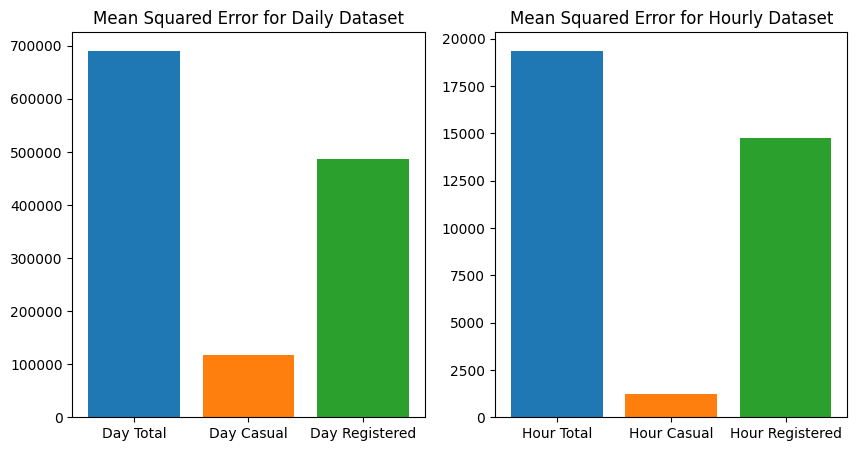

In [ ]:
labels = ['Day Total', 'Hour Total',
          'Day Casual', 'Hour Casual',
          'Day Registered', 'Hour Registered']
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

for i, j in zip(labels, MSEs):
  if 'Day' in i:
    ax1.bar(i, j)
  else:
    ax2.bar(i, j)

ax1.set_title('Mean Squared Error for Daily Dataset')

ax2.set_title('Mean Squared Error for Hourly Dataset')



Text(0.5, 1.0, 'R2 Score for Hourly Dataset')

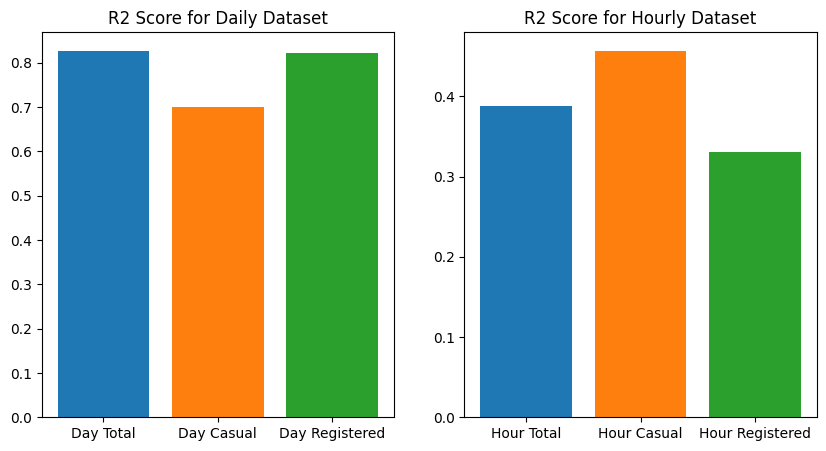

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

for i, j in zip(labels, r2s):
  if 'Day' in i:
    ax1.bar(i, j)
  else:
    ax2.bar(i, j)

ax1.set_title('R2 Score for Daily Dataset')
ax2.set_title('R2 Score for Hourly Dataset')



(3476,)
(3476,)


Text(0.5, 1.0, 'Actual vs Predicted for Hourly Registered Dataset')

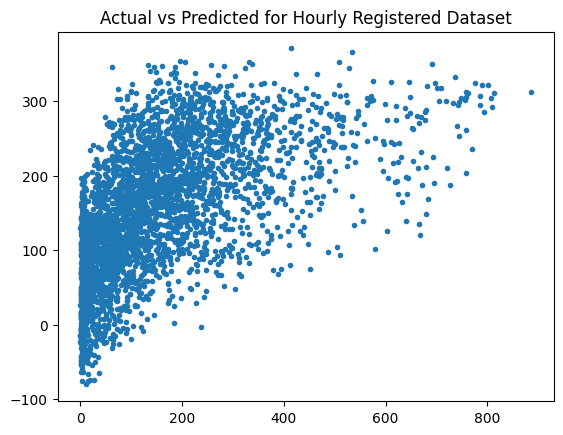

In [ ]:
# graphical output for last model Hourly Registered
print(y3_pred.shape)
print(y3_test_hour.shape)
plt.plot(y3_test_hour, y3_pred, '.')
plt.title('Actual vs Predicted for Hourly Registered Dataset')
# plt.plot(y3_test_hour, '.')

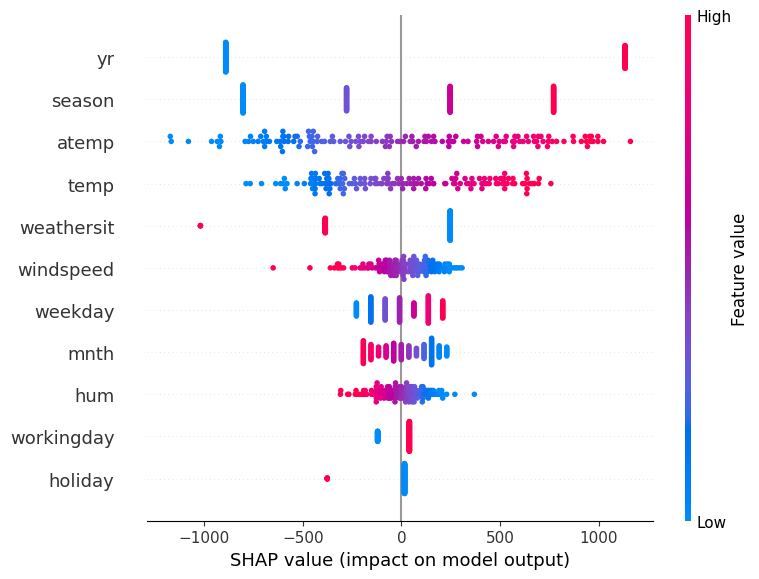

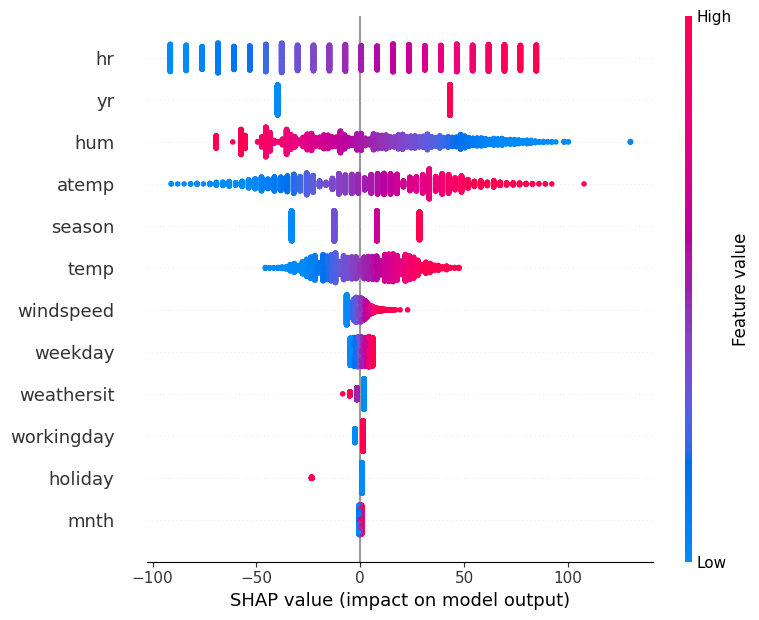

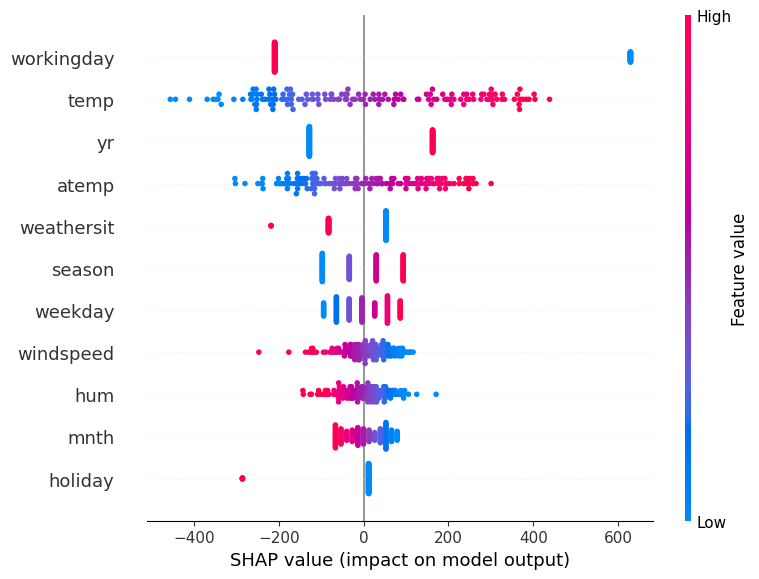

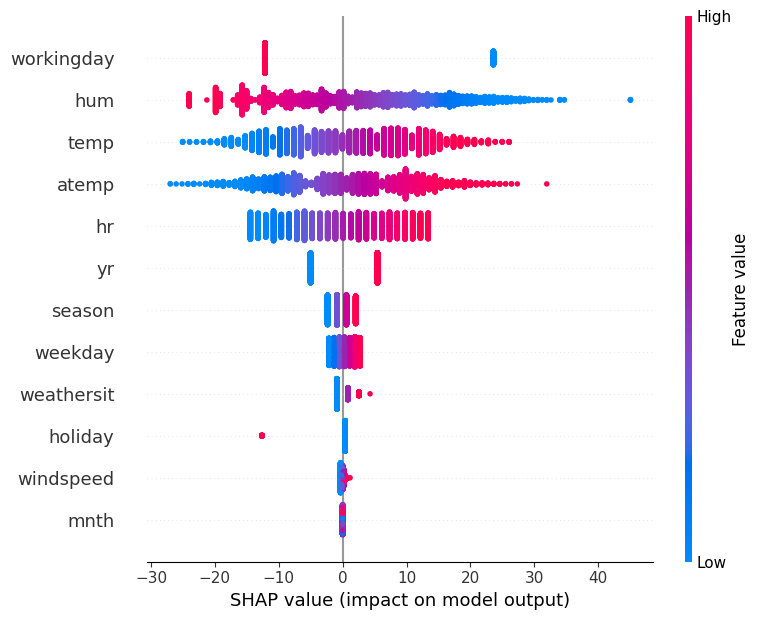

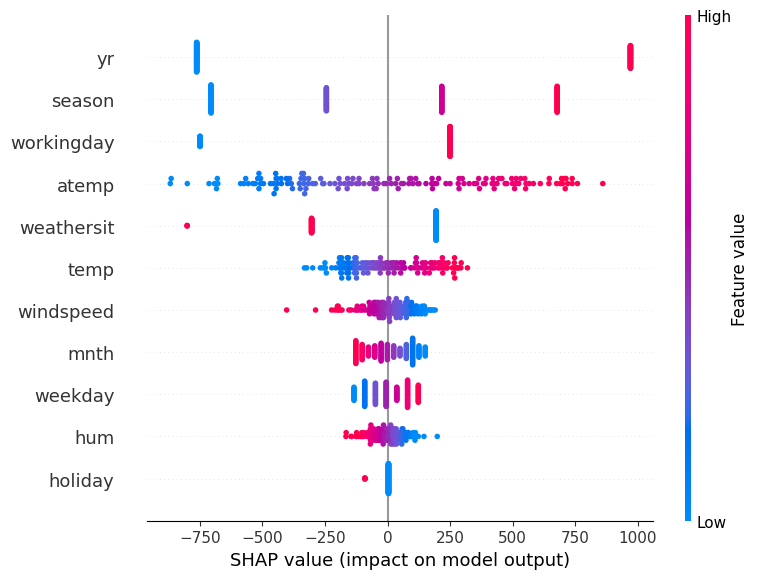

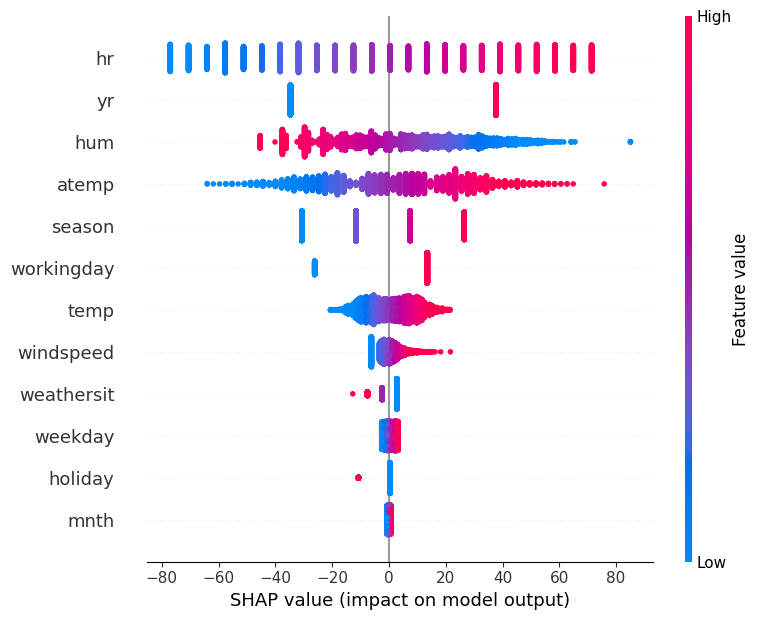

In [ ]:
# explain the predictions of day model for total ridership using SHAP
explainer = shap.explainers.Linear(model_day_total, X1_test_day)
shap_values = explainer(X1_test_day)
shap.summary_plot(shap_values, X1_test_day)

# explain the predictions of day model for total ridership using SHAP
explainer = shap.explainers.Linear(model_hour_total, X1_test_hour)
shap_values = explainer(X1_test_hour)
shap.summary_plot(shap_values, X1_test_hour)

# explain the predictions of day model for casual ridership using SHAP
explainer = shap.explainers.Linear(model_day_casual, X2_test_day)
shap_values = explainer(X2_test_day)
shap.summary_plot(shap_values, X2_test_day)

# explain the predictions of day model for casual ridership using SHAP
explainer = shap.explainers.Linear(model_hour_casual, X2_test_hour)
shap_values = explainer(X2_test_hour)
shap.summary_plot(shap_values, X2_test_hour)

# explain the predictions of day model for registered ridership using SHAP
explainer = shap.explainers.Linear(model_day_reg, X3_test_day)
shap_values = explainer(X3_test_day)
shap.summary_plot(shap_values, X3_test_day)

# explain the predictions of day model for registered ridership using SHAP
explainer = shap.explainers.Linear(model_hour_reg, X3_test_hour)
shap_values = explainer(X3_test_hour)
shap.summary_plot(shap_values, X3_test_hour)

# SVM Regression

In [ ]:
from sklearn.svm import SVR

tscv = TimeSeriesSplit(n_splits=5)

MSEs = []
r2s = []

model_day_total = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

# train day total cnt
mse_1_day = -cross_val_score(model_day_total, X1_train_day, y1_train_day, cv=tscv, scoring='neg_mean_squared_error')
print('Average Training MSE for #1 (total count) for "day" df:', np.mean(mse_1_day))
r2_1_day = cross_val_score(model_day_total, X1_train_day, y1_train_day, cv=tscv, scoring='r2')
print('Average Training R2 for #1 (total count) for "day" df:', np.mean(r2_1_day))
print('\n')

# test day total cnt
model_day_total.fit(X1_train_day, y1_train_day)
y1_pred = model_day_total.predict(X1_test_day)
test_mse = mean_squared_error(y1_test_day, y1_pred)
print('Test MSE for #1 (total count) for "day" df:', test_mse)
test_r2 = r2_score(y1_test_day, y1_pred)
print('Test R2 for #1 (total count) for "day" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

model_hour_total = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

# train hour total cnt
mse_1_hour = -cross_val_score(model_hour_total, X1_train_hour, y1_train_hour, cv=tscv, scoring='neg_mean_squared_error')
print('Average Training MSE for #1 (total count) for "hour" df:', np.mean(mse_1_hour))
r2_1_hour = cross_val_score(model_hour_total, X1_train_hour, y1_train_hour, cv=tscv, scoring='r2')
print('Average Training R2 for #1 (total count) for "hour" df:', np.mean(r2_1_hour))
print('\n')

# test hour total cnt
model_hour_total.fit(X1_train_hour, y1_train_hour)
y1_pred = model_hour_total.predict(X1_test_hour)
test_mse = mean_squared_error(y1_test_hour, y1_pred)
print('Test MSE for #1 (total count) for "hour" df:', test_mse)
test_r2 = r2_score(y1_test_hour, y1_pred)
print('Test R2 for #1 (total count) for "hour" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

model_day_casual = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

# train day casual
mse_2_day = -cross_val_score(model_day_casual, X2_train_day, y2_train_day, cv=tscv, scoring='neg_mean_squared_error')
print('Average Training MSE for #2 (casuals only) for "day" df:', np.mean(mse_1_day))
r2_2_day = cross_val_score(model_day_casual, X2_train_day, y2_train_day, cv=tscv, scoring='r2')
print('Average Training R2 for #2 (casuals only) for "day" df:', np.mean(r2_2_day))
print('\n')

# test day casual
model_day_casual.fit(X2_train_day, y2_train_day)
y2_pred = model_day_casual.predict(X2_test_day)
test_mse = mean_squared_error(y2_test_day, y2_pred)
print('Test MSE for #2 (casuals only) for "day" df:', test_mse)
test_r2 = r2_score(y2_test_day, y2_pred)
print('Test R2 for #2 (casuals only) for "day" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

model_hour_casual = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

# train hour casual
mse_2_hour = -cross_val_score(model_hour_casual, X2_train_hour, y2_train_hour, cv=tscv, scoring='neg_mean_squared_error')
print('Average Training MSE for #2 (casuals only) for "hour" df:', np.mean(mse_2_hour))
r2_2_hour = cross_val_score(model_hour_casual, X2_train_hour, y2_train_hour, cv=tscv, scoring='r2')
print('Average Training R2 for #2 (casuals only) for "hour" df:', np.mean(r2_2_hour))
print('\n')

# test hour casual
model_hour_casual.fit(X2_train_hour, y2_train_hour)
y2_pred = model_hour_casual.predict(X2_test_hour)
test_mse = mean_squared_error(y2_test_hour, y2_pred)
print('Test MSE for #2 (casuals only) for "hour" df:', test_mse)
test_r2 = r2_score(y2_test_hour, y2_pred)
print('Test R2 for #2 (casuals only) for "hour" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

model_day_reg = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

# train day registered
mse_3_day = -cross_val_score(model_day_reg, X3_train_day, y3_train_day, cv=tscv, scoring='neg_mean_squared_error')
print('Average MSE for #3 (registered only) for "day" df:', np.mean(mse_3_day))
r2_3_day = cross_val_score(model_day_reg, X3_train_day, y3_train_day, cv=tscv, scoring='r2')
print('Average R2 for #3 (registered only) for "day" df:', np.mean(r2_3_day))
print('\n')

# test day registered
model_day_reg.fit(X3_train_day, y3_train_day)
y3_pred = model_day_reg.predict(X3_test_day)
test_mse = mean_squared_error(y3_test_day, y3_pred)
print('Test MSE for #3 (registered only) for "day" df:', test_mse)
test_r2 = r2_score(y3_test_day, y3_pred)
print('Test R2 for #3 (registered only) for "day" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

model_hour_reg = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

# train hour registered
mse_3_hour = -cross_val_score(model_hour_reg, X3_train_hour, y3_train_hour, cv=tscv, scoring='neg_mean_squared_error')
print('Average Training MSE for #3 (registered only) for "hour" df:', np.mean(mse_3_hour))
r2_3_hour = cross_val_score(model_hour_reg, X3_train_hour, y3_train_hour, cv=tscv, scoring='r2')
print('Average Training R2 for #3 (registered only) for "hour" df:', np.mean(r2_3_hour))
print('\n')

# test hour registered
model_hour_reg.fit(X3_train_hour, y3_train_hour)
y3_pred = model_hour_reg.predict(X3_test_hour)
test_mse = mean_squared_error(y3_test_hour, y3_pred)
print('Test MSE for #3 (registered only) for "hour" df:', test_mse)
test_r2 = r2_score(y3_test_hour, y3_pred)
print('Test R2 for #3 (registered only) for "hour" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

Average Training MSE for #1 (total count) for "day" df: 3601161.1289102347
Average Training R2 for #1 (total count) for "day" df: -0.007662902473274213


Test MSE for #1 (total count) for "day" df: 3841201.145807883
Test R2 for #1 (total count) for "day" df: 0.04206635772222789


Average Training MSE for #1 (total count) for "hour" df: 15313.389945021592
Average Training R2 for #1 (total count) for "hour" df: 0.5376309226477846


Test MSE for #1 (total count) for "hour" df: 6843.878121987354
Test R2 for #1 (total count) for "hour" df: 0.7838689651219555


Average Training MSE for #2 (casuals only) for "day" df: 3601161.1289102347
Average Training R2 for #2 (casuals only) for "day" df: -0.033742821333717775


Test MSE for #2 (casuals only) for "day" df: 324387.21730620204
Test R2 for #2 (casuals only) for "day" df: 0.1673912890510365


Average Training MSE for #2 (casuals only) for "hour" df: 820.1328721062043
Average Training R2 for #2 (casuals only) for "hour" df: 0.6570222768479194



  0%|          | 0/50 [00:00<?, ?it/s]

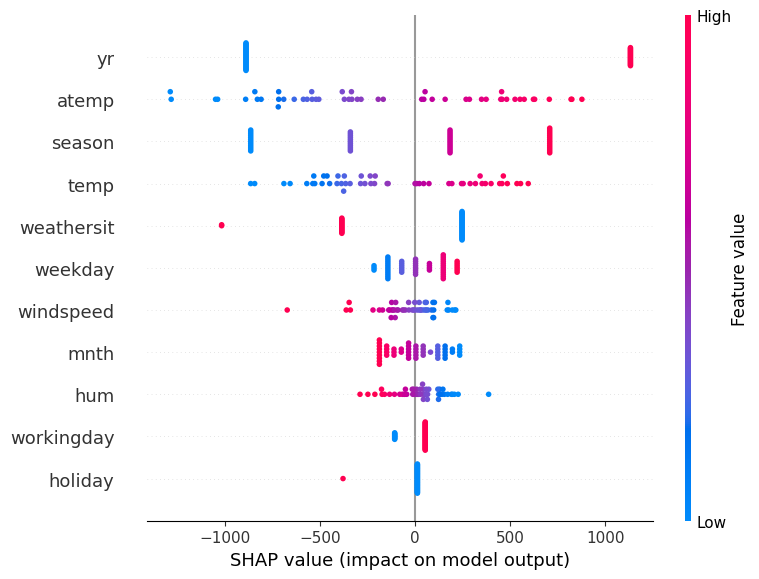

In [ ]:
# explain the predictions of day model for total ridership using SHAP
X1_train_day100 = shap.utils.sample(X1_train_day, 100)
X1_test_day50 = shap.utils.sample(X1_test_day, 50)
explainer = shap.KernelExplainer(model_day_total.predict, X1_train_day100)
shap_values = explainer.shap_values(X1_test_day50)
shap.summary_plot(shap_values, X1_test_day50)

  0%|          | 0/50 [00:00<?, ?it/s]

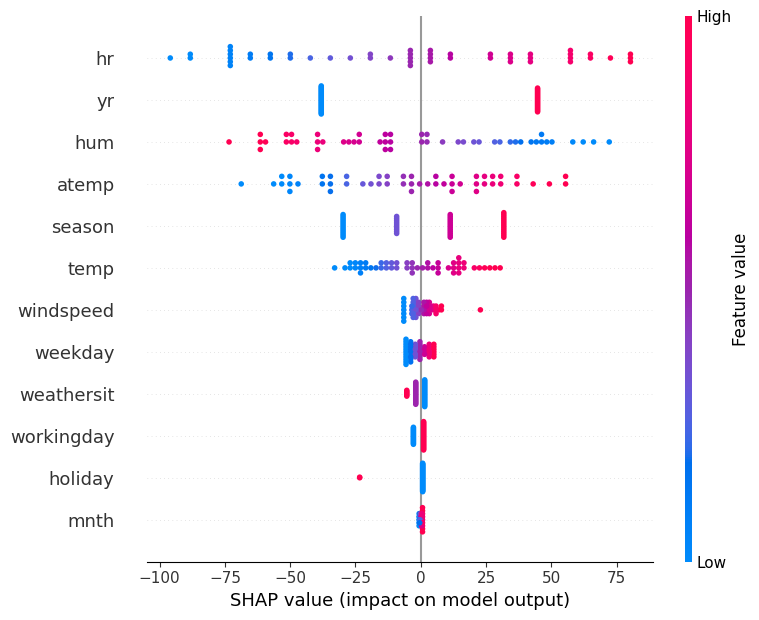

In [ ]:
# explain the predictions of day model for total ridership using SHAP
X1_train_hour100 = shap.utils.sample(X1_train_hour, 100)
X1_test_hour50 = shap.utils.sample(X1_test_hour, 50)
explainer = shap.KernelExplainer(model_hour_total.predict, X1_train_hour100)
shap_values = explainer.shap_values(X1_test_hour50)
shap.summary_plot(shap_values, X1_test_hour50)

  0%|          | 0/50 [00:00<?, ?it/s]

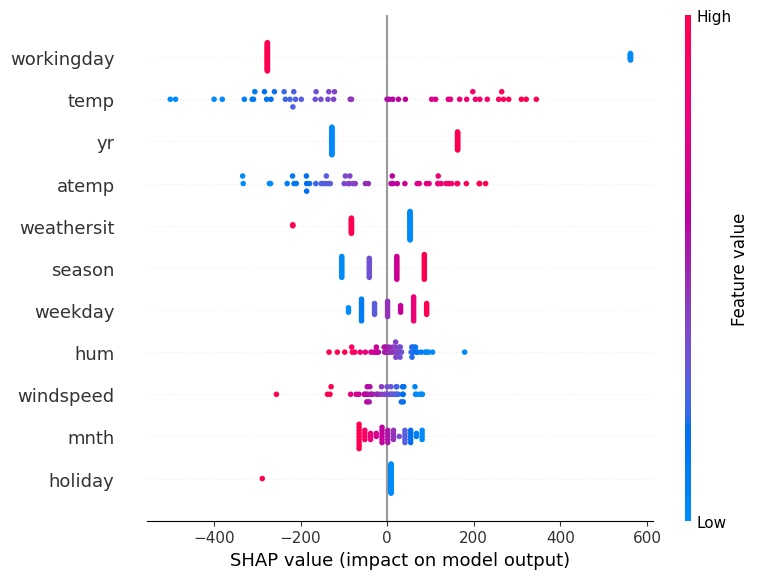

In [ ]:
# explain the predictions of day model for casual ridership using SHAP
X2_train_day100 = shap.utils.sample(X2_train_day, 100)
X2_test_day50 = shap.utils.sample(X2_test_day, 50)
explainer = shap.KernelExplainer(model_day_casual.predict, X2_train_day100)
shap_values = explainer.shap_values(X2_test_day50)
shap.summary_plot(shap_values, X2_test_day50)

  0%|          | 0/25 [00:00<?, ?it/s]

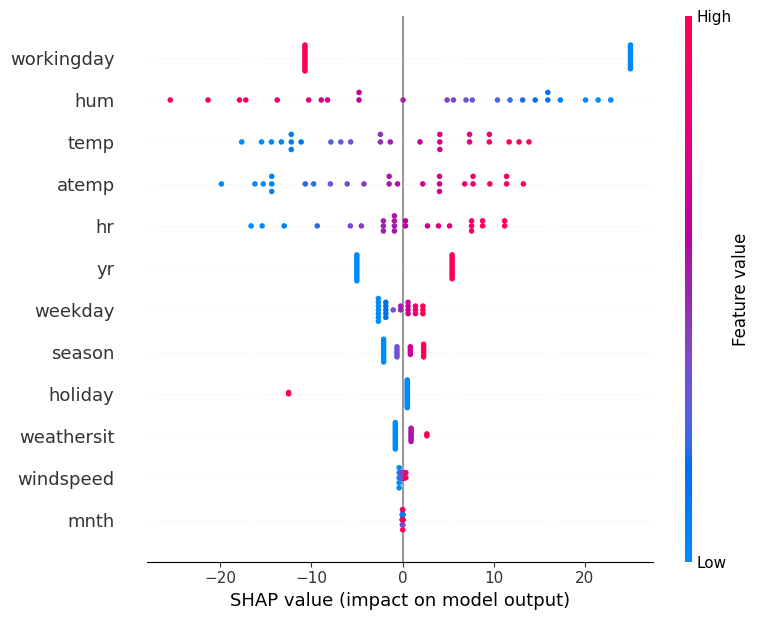

In [ ]:
# explain the predictions of day model for casual ridership using SHAP
X2_train_hour100 = shap.utils.sample(X2_train_hour, 50)
X2_test_hour50 = shap.utils.sample(X2_test_hour, 25)
explainer = shap.KernelExplainer(model_hour_casual.predict, X2_train_hour100)
shap_values = explainer.shap_values(X2_test_hour50)
shap.summary_plot(shap_values, X2_test_hour50)

  0%|          | 0/50 [00:00<?, ?it/s]

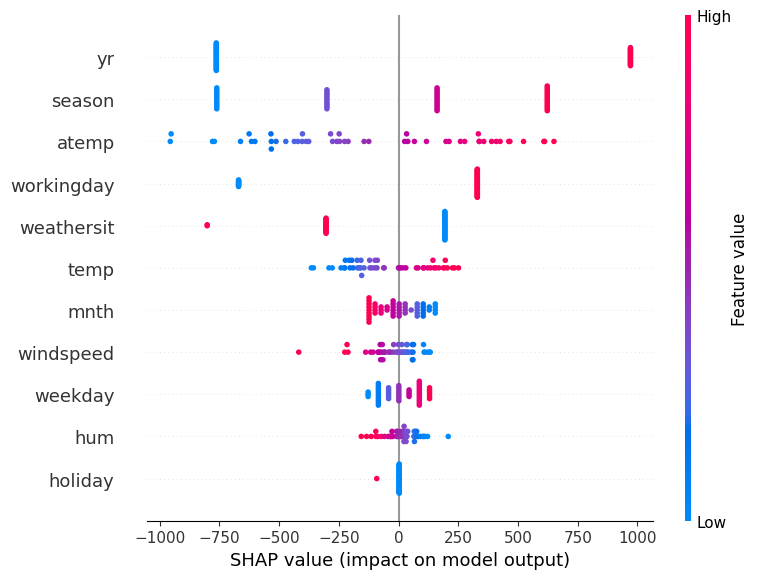

In [ ]:
# explain the predictions of day model for registered ridership using SHAP
X3_train_day100 = shap.utils.sample(X3_train_day, 100)
X3_test_day50 = shap.utils.sample(X3_test_day, 50)
explainer = shap.KernelExplainer(model_day_reg.predict, X3_train_day100)
shap_values = explainer.shap_values(X3_test_day50)
shap.summary_plot(shap_values, X3_test_day50)

  0%|          | 0/50 [00:00<?, ?it/s]

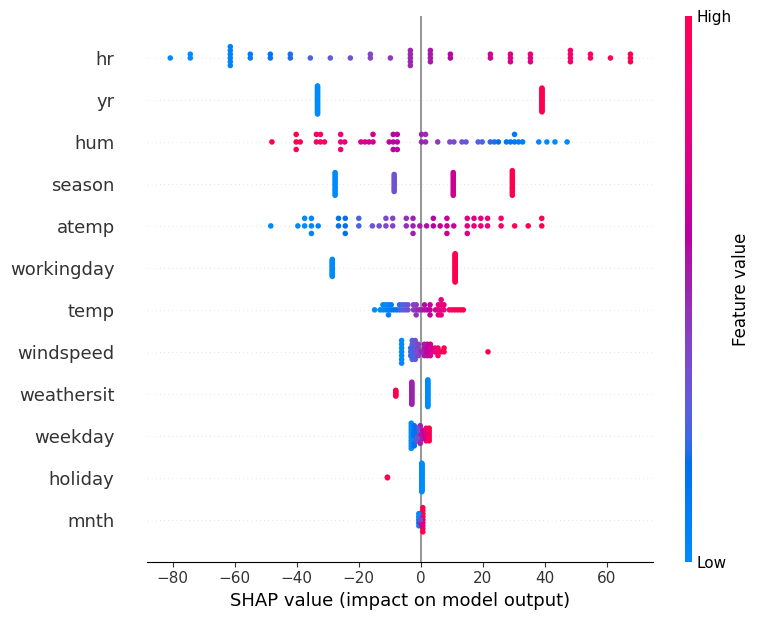

In [ ]:
# explain the predictions of day model for registered ridership using SHAP
X3_train_hour100 = shap.utils.sample(X3_train_hour, 100)
X3_test_hour50 = shap.utils.sample(X3_test_hour, 50)
explainer = shap.KernelExplainer(model_hour_reg.predict, X3_train_hour100)
shap_values = explainer.shap_values(X3_test_hour50)
shap.summary_plot(shap_values, X3_test_hour50)

Graphing:

Text(0.5, 1.0, 'Mean Squared Error for Hourly Dataset')

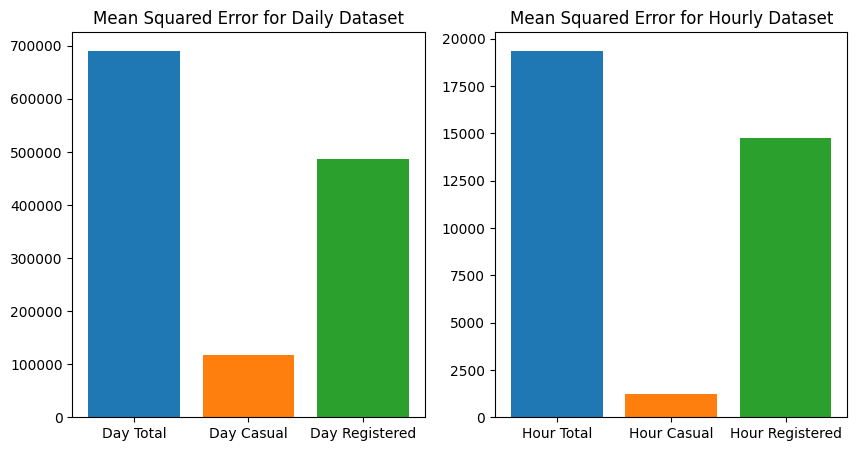

In [ ]:
labels = ['Day Total', 'Hour Total',
          'Day Casual', 'Hour Casual',
          'Day Registered', 'Hour Registered']
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

for i, j in zip(labels, MSEs):
  if 'Day' in i:
    ax1.bar(i, j)
  else:
    ax2.bar(i, j)

ax1.set_title('Mean Squared Error for Daily Dataset')

ax2.set_title('Mean Squared Error for Hourly Dataset')



Text(0.5, 1.0, 'R2 Score for Hourly Dataset')

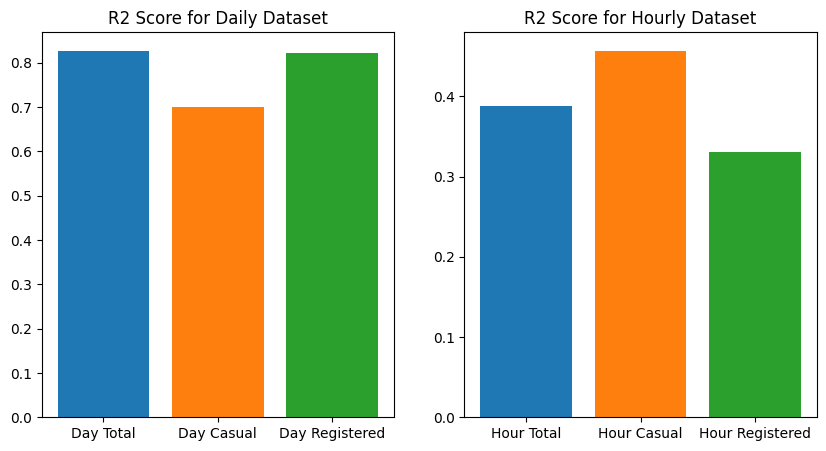

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

for i, j in zip(labels, r2s):
  if 'Day' in i:
    ax1.bar(i, j)
  else:
    ax2.bar(i, j)

ax1.set_title('R2 Score for Daily Dataset')
ax2.set_title('R2 Score for Hourly Dataset')



(3476,)
(3476,)


Text(0.5, 1.0, 'Actual vs Predicted for Hourly Registered Dataset')

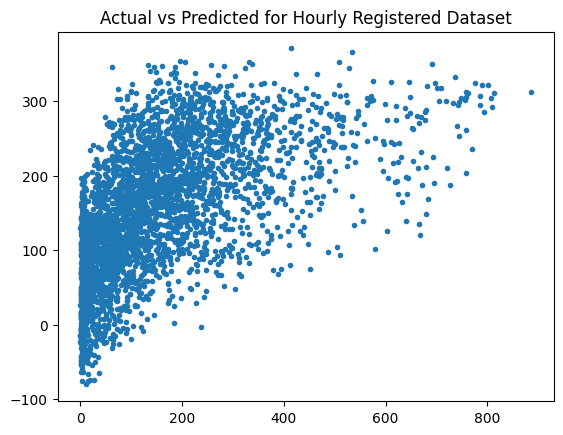

In [ ]:
# graphical output for last model Hourly Registered
print(y3_pred.shape)
print(y3_test_hour.shape)
plt.plot(y3_test_hour, y3_pred, '.')
plt.title('Actual vs Predicted for Hourly Registered Dataset')
# plt.plot(y3_test_hour, '.')

# XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV

def get_params(x_train, y_train):
  # Define the parameter grid
  param_grid = {
      'max_depth': [3, 4, 5],
      'min_child_weight': [1, 2, 3],
      'eta': [0.3, 0.1, 0.03],
      'subsample': [0.8, 1.0],
      'colsample_bytree': [0.8, 1.0],
  }

  # Initialize the XGBoost Regressor
  xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

  # Set up GridSearchCV
  grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid,
                            scoring='neg_mean_squared_error',
                            cv=3, verbose=1, n_jobs=-1)

  # Fit GridSearchCV
  grid_search.fit(x_train, y_train)
  return grid_search.best_params_

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
def xgboost_eval(dtest, dtrain, y_test, params, num_round):
  # Training the model
  bst = xgb.train(params, dtrain, num_round)

  # Predicting on the test set
  preds = bst.predict(dtest)

  # Evaluate the performance
  mse = mean_squared_error(y_test, preds)
  r2 = r2_score(y_test, preds)

  return bst, mse, r2


MSEs = []
r2s = []

# Set the parameters for XGBoost
# params = {
#     'max_depth': 3,  # the maximum depth of each tree
#     'eta': 0.3,      # the training step for each iteration
#     'objective': 'reg:squarederror',  # regression with squared loss
#     'eval_metric': 'logloss' # evaluation metric
# }


# Number of training iterations
num_round = 100

# Convert the dataset into an optimized data structure called Dmatrix
d1_train_day = xgb.DMatrix(X1_train_day, label=y1_train_day)
d1_test_day = xgb.DMatrix(X1_test_day, label=y1_test_day)
model_day_total, mse1_train_day, r2_1_train_day = xgboost_eval(d1_test_day, d1_train_day, y1_test_day, get_params(X1_train_day, y1_train_day), num_round)
MSEs.append(mse1_train_day)
r2s.append(r2_1_train_day)
print(f"MSE #1 (total count) for day: {mse1_train_day:.2f}")
print(f"R^2 Score #1 (total count) for day: {r2_1_train_day:.2f}")

# Convert the dataset into an optimized data structure called Dmatrix
d1_train_hour = xgb.DMatrix(X1_train_hour, label=y1_train_hour)
d1_test_hour = xgb.DMatrix(X1_test_hour, label=y1_test_hour)
model_hour_total, mse1_train_hour, r2_1_train_hour = xgboost_eval(d1_test_hour, d1_train_hour, y1_test_hour, get_params(X1_train_hour, y1_train_hour), num_round)
MSEs.append(mse1_train_hour)
r2s.append(r2_1_train_hour)
print(f"MSE #1 (total count) for hour: {mse1_train_hour:.2f}")
print(f"R^2 Score #1 (total count) for hour: {r2_1_train_hour:.2f}")

print('\n')

# Convert the dataset into an optimized data structure called Dmatrix
d2_train_day = xgb.DMatrix(X2_train_day, label=y2_train_day)
d2_test_day = xgb.DMatrix(X2_test_day, label=y2_test_day)
model_day_casual, mse2_train_day, r2_2_train_day = xgboost_eval(d2_test_day, d2_train_day, y2_test_day, get_params(X2_train_day, y2_train_day), num_round)
MSEs.append(mse2_train_day)
r2s.append(r2_2_train_day)
print(f"MSE #2 (casuals only) for day: {mse2_train_day:.2f}")
print(f"R^2 Score #2 (casuals only) for day: {r2_2_train_day:.2f}")

# Convert the dataset into an optimized data structure called Dmatrix
d2_train_hour = xgb.DMatrix(X2_train_hour, label=y2_train_hour)
d2_test_hour = xgb.DMatrix(X2_test_hour, label=y2_test_hour)
model_hour_casual, mse2_train_hour, r2_2_train_hour = xgboost_eval(d2_test_hour, d2_train_hour, y2_test_hour, get_params(X2_train_hour, y2_train_hour), num_round)
MSEs.append(mse2_train_hour)
r2s.append(r2_2_train_hour)
print(f"MSE #2 (casuals only) for hour: {mse2_train_hour:.2f}")
print(f"R^2 Score #2 (casuals only) for hour: {r2_2_train_hour:.2f}")

print('\n')

# Convert the dataset into an optimized data structure called Dmatrix
d3_train_day = xgb.DMatrix(X3_train_day, label=y3_train_day)
d3_test_day = xgb.DMatrix(X3_test_day, label=y3_test_day)
model_day_reg, mse3_train_day, r2_3_train_day = xgboost_eval(d3_test_day, d3_train_day, y3_test_day, get_params(X3_train_day, y3_train_day), num_round)
MSEs.append(mse3_train_day)
r2s.append(r2_3_train_day)
print(f"MSE #3 (registered only) for day: {mse3_train_day:.2f}")
print(f"R^2 Score #3 (registered only) for day: {r2_3_train_day:.2f}")

# Convert the dataset into an optimized data structure called Dmatrix
d3_train_hour = xgb.DMatrix(X3_train_hour, label=y3_train_hour)
d3_test_hour = xgb.DMatrix(X3_test_hour, label=y3_test_hour)
model_hour_reg, mse3_train_hour, r2_3_train_hour = xgboost_eval(d3_test_hour, d3_train_hour, y3_test_hour, get_params(X3_train_hour, y3_train_hour), num_round)
MSEs.append(mse3_train_hour)
r2s.append(r2_3_train_hour)
print(f"MSE #3 (registered only) for hour: {mse3_train_hour:.2f}")
print(f"R^2 Score #3 (registered only) for hour: {r2_3_train_hour:.2f}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
MSE #1 (total count) for day: 415348.66
R^2 Score #1 (total count) for day: 0.90
Fitting 3 folds for each of 108 candidates, totalling 324 fits
MSE #1 (total count) for hour: 1792.59
R^2 Score #1 (total count) for hour: 0.94


Fitting 3 folds for each of 108 candidates, totalling 324 fits
MSE #2 (casuals only) for day: 63226.27
R^2 Score #2 (casuals only) for day: 0.84
Fitting 3 folds for each of 108 candidates, totalling 324 fits
MSE #2 (casuals only) for hour: 206.11
R^2 Score #2 (casuals only) for hour: 0.91


Fitting 3 folds for each of 108 candidates, totalling 324 fits
MSE #3 (registered only) for day: 284750.99
R^2 Score #3 (registered only) for day: 0.90
Fitting 3 folds for each of 108 candidates, totalling 324 fits
MSE #3 (registered only) for hour: 1231.09
R^2 Score #3 (registered only) for hour: 0.94


Graphing:

Text(0.5, 1.0, 'Mean Squared Error for Hourly Dataset')

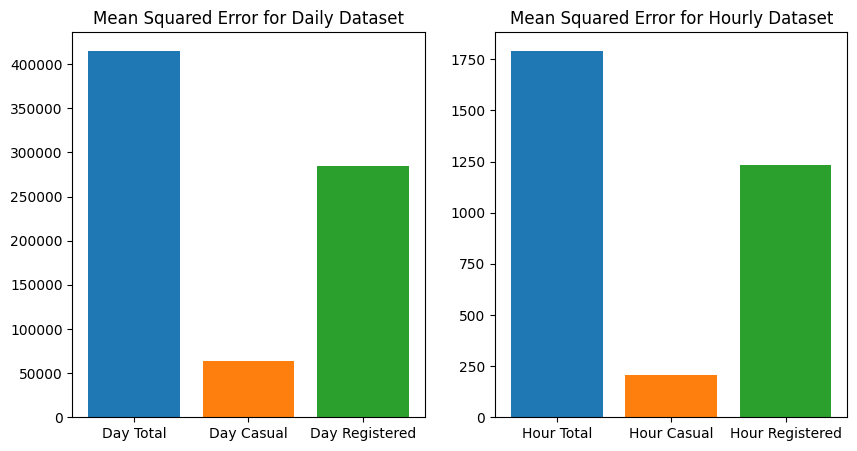

In [ ]:
labels = ['Day Total', 'Hour Total',
          'Day Casual', 'Hour Casual',
          'Day Registered', 'Hour Registered']
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

for i, j in zip(labels, MSEs):
  if 'Day' in i:
    ax1.bar(i, j)
  else:
    ax2.bar(i, j)

ax1.set_title('Mean Squared Error for Daily Dataset')

ax2.set_title('Mean Squared Error for Hourly Dataset')



Text(0.5, 1.0, 'R2 Score for Hourly Dataset')

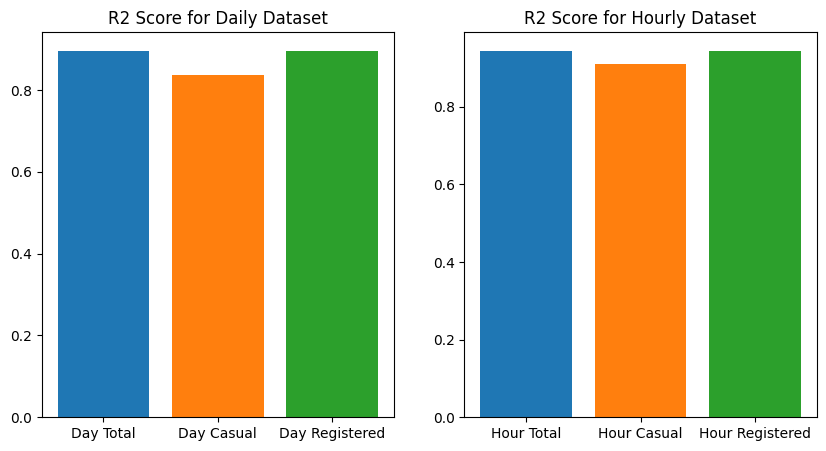

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

for i, j in zip(labels, r2s):
  if 'Day' in i:
    ax1.bar(i, j)
  else:
    ax2.bar(i, j)

ax1.set_title('R2 Score for Daily Dataset')
ax2.set_title('R2 Score for Hourly Dataset')



[20:42:45] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


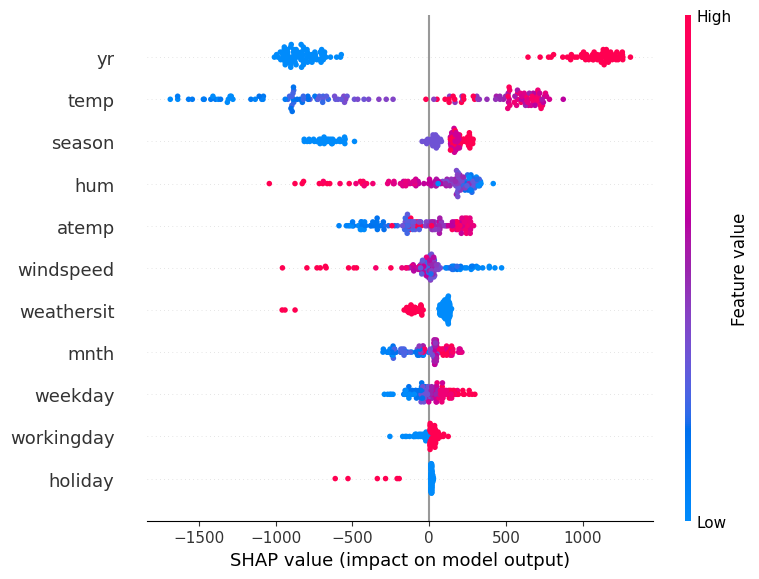

In [ ]:
# explain the predictions of day model for total ridership using SHAP
# X1_train_day100 = shap.utils.sample(X1_train_day, -1)
# X1_test_day50 = shap.utils.sample(X1_test_day, -1)
explainer = shap.TreeExplainer(model_day_total, X1_train_day)
shap_values = explainer.shap_values(X1_test_day)
shap.summary_plot(shap_values, X1_test_day)

[20:55:21] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 96%|=================== | 3349/3476 [00:19<00:00]       

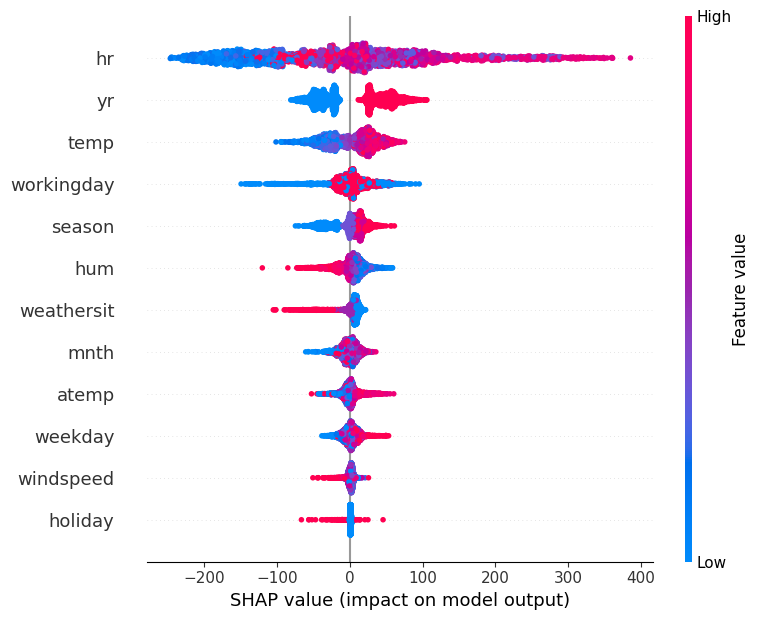

In [ ]:
# explain the predictions of day model for total ridership using SHAP
# X1_train_hour100 = shap.utils.sample(X1_train_hour, 100)
# X1_test_hour50 = shap.utils.sample(X1_test_hour, 50)
explainer = shap.TreeExplainer(model_hour_total, X1_train_hour)
shap_values = explainer.shap_values(X1_test_hour)
shap.summary_plot(shap_values, X1_test_hour)

[20:55:41] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


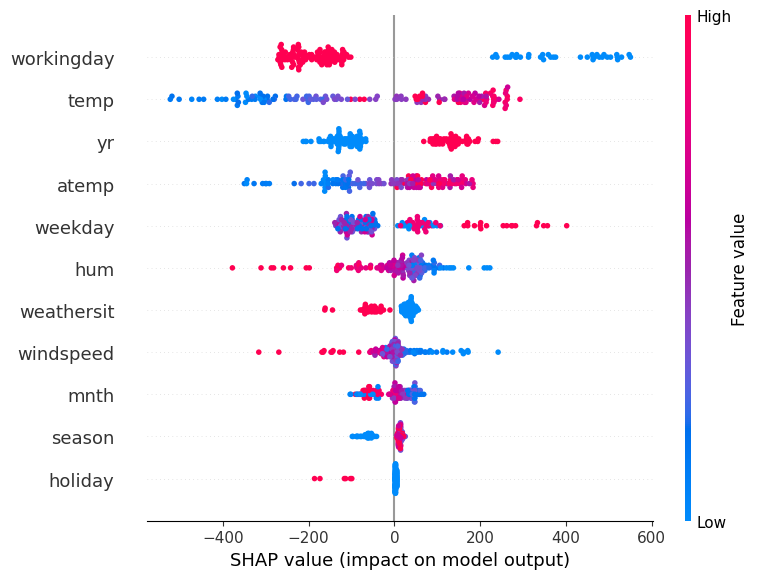

In [ ]:
# explain the predictions of day model for casual ridership using SHAP
# X2_train_day100 = shap.utils.sample(X2_train_day, 100)
# X2_test_day50 = shap.utils.sample(X2_test_day, 50)
explainer = shap.TreeExplainer(model_day_casual, X2_train_day)
shap_values = explainer.shap_values(X2_test_day)
shap.summary_plot(shap_values, X2_test_day)

[20:55:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 96%|=================== | 3330/3476 [00:15<00:00]       

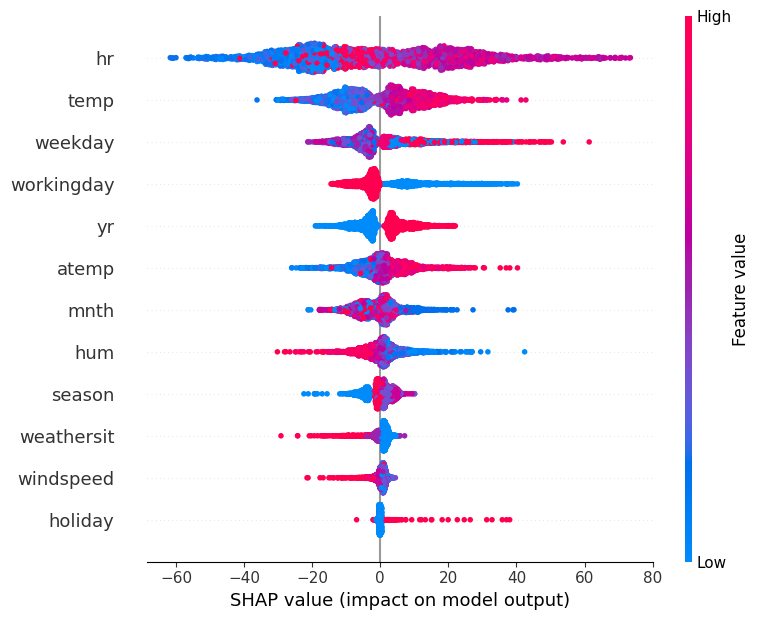

In [ ]:
# explain the predictions of day model for casual ridership using SHAP
# X2_train_hour100 = shap.utils.sample(X2_train_hour, 100)
# X2_test_hour50 = shap.utils.sample(X2_test_hour, 50)
explainer = shap.TreeExplainer(model_hour_casual, X2_train_hour)
shap_values = explainer.shap_values(X2_test_hour)
shap.summary_plot(shap_values, X2_test_hour)

[20:55:59] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


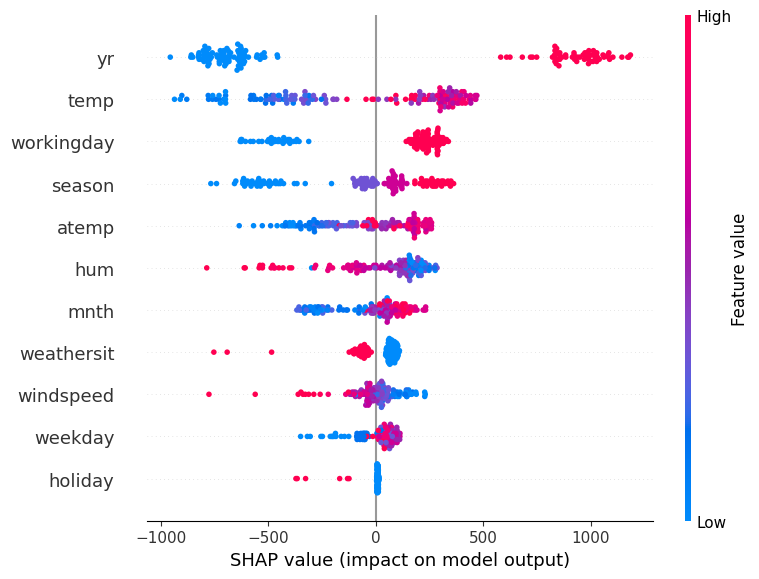

In [ ]:
# explain the predictions of day model for registered ridership using SHAP
# X3_train_day100 = shap.utils.sample(X3_train_day, 100)
# X3_test_day50 = shap.utils.sample(X3_test_day, 50)
explainer = shap.TreeExplainer(model_day_reg, X3_train_day)
shap_values = explainer.shap_values(X3_test_day)
shap.summary_plot(shap_values, X3_test_day)

[20:56:01] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 95%|=================== | 3308/3476 [00:17<00:00]       

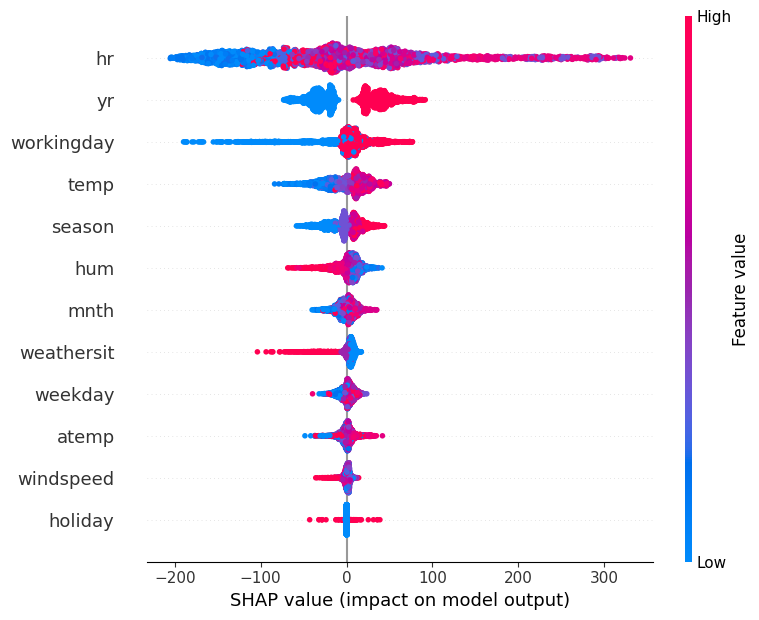

In [ ]:
# explain the predictions of day model for registered ridership using SHAP
# X3_train_hour100 = shap.utils.sample(X3_train_hour, 100)
# X3_test_hour50 = shap.utils.sample(X3_test_hour, 50)
explainer = shap.TreeExplainer(model_hour_reg, X3_train_hour)
shap_values = explainer.shap_values(X3_test_hour)
shap.summary_plot(shap_values, X3_test_hour)

# EDA + PCA

In [ ]:
from sklearn.decomposition import PCA
pca_day = PCA(n_components=2)  # Adjust n_components as needed
pca_day_result = pca_day.fit_transform(day)

# Explained variance ratio
print("Explained Variance Ratio:", pca_day.explained_variance_ratio_)

pca_hour = PCA(n_components=2)  # Adjust n_components as needed
pca_hour_result = pca_hour.fit_transform(hour)

# Explained variance ratio
print("Explained Variance Ratio:", pca_hour.explained_variance_ratio_)

Explained Variance Ratio: [0.92950567 0.07049185]
Explained Variance Ratio: [0.96098056 0.03802317]


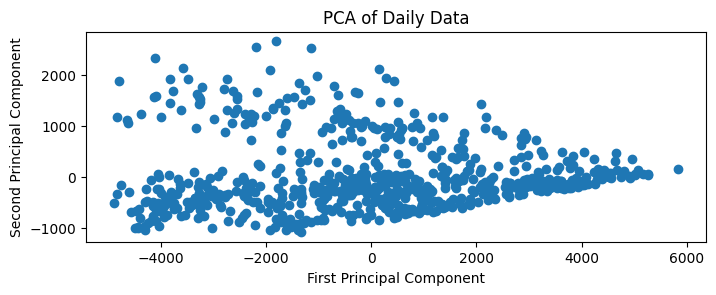

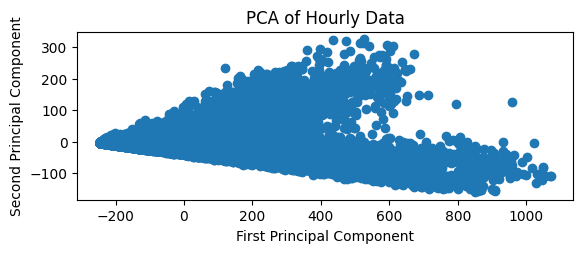

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(2,1,1)
plt.scatter(pca_day_result[:, 0], pca_day_result[:, 1])
plt.title("PCA of Daily Data")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

plt.subplot(2,1,2)
plt.scatter(pca_hour_result[:, 0], pca_hour_result[:, 1])
plt.title("PCA of Hourly Data")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

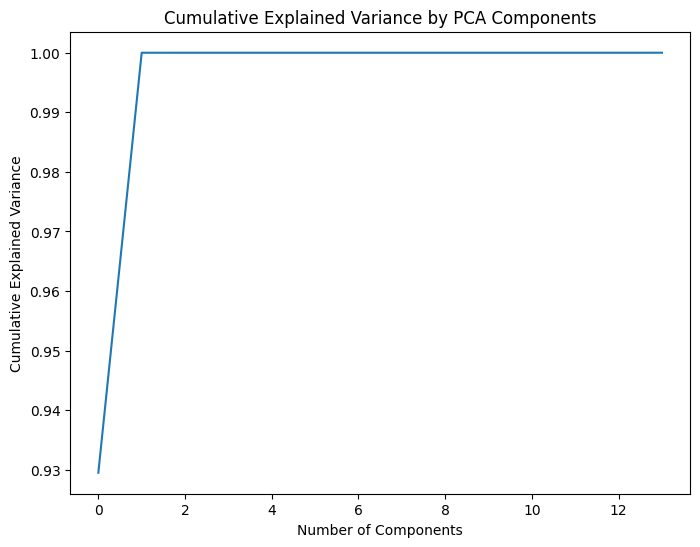

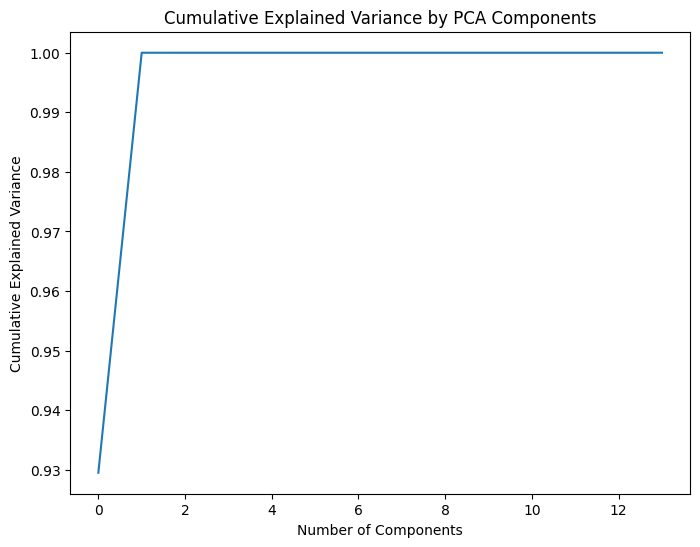

In [ ]:
pca_full_day = PCA(n_components=None)
pca_full_day.fit(day)
cumulative_variance_day = np.cumsum(pca_full_day.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance_day)
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

pca_full_hour = PCA(n_components=None)
pca_full_hour.fit(day)
cumulative_variance_hour = np.cumsum(pca_full_hour.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance_hour)
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

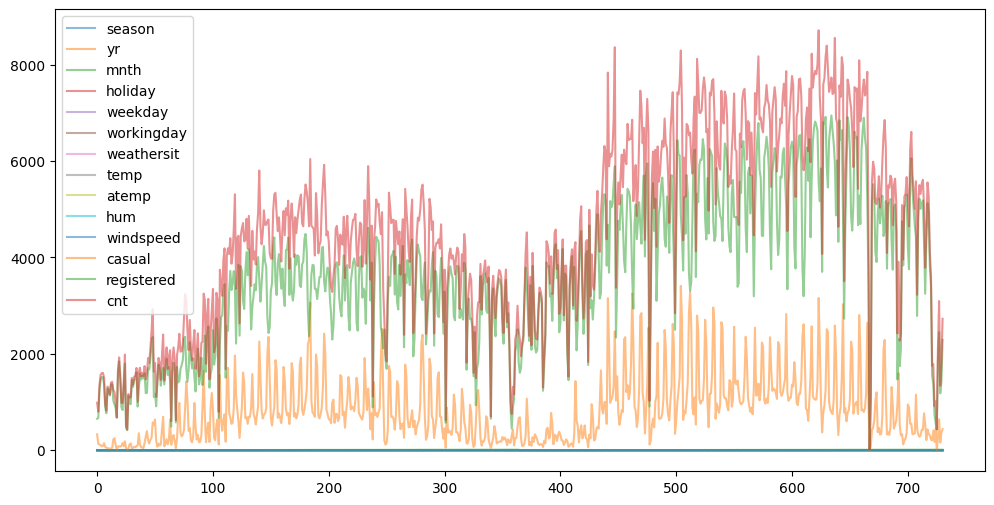

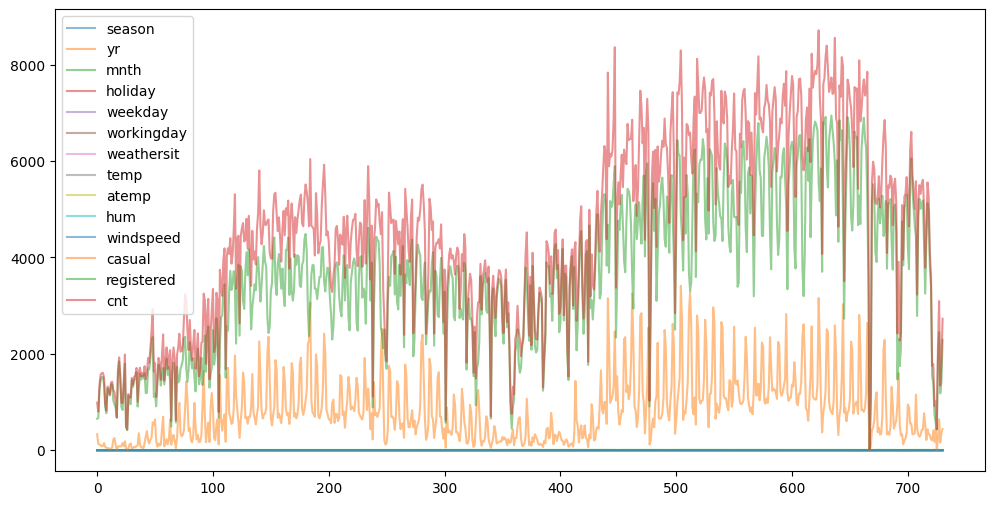

In [ ]:
# Reconstruct data using the first two principal components
reconstructed_data = pca_day.inverse_transform(pca_day_result)
reconstructed_day = pd.DataFrame(reconstructed_data, columns=day.columns, index=day.index)

# Plotting original vs reconstructed data
day.plot(figsize=(12, 6), alpha=0.5)
plt.show()
reconstructed_day.plot(figsize=(12, 6), alpha=0.5)
plt.show()


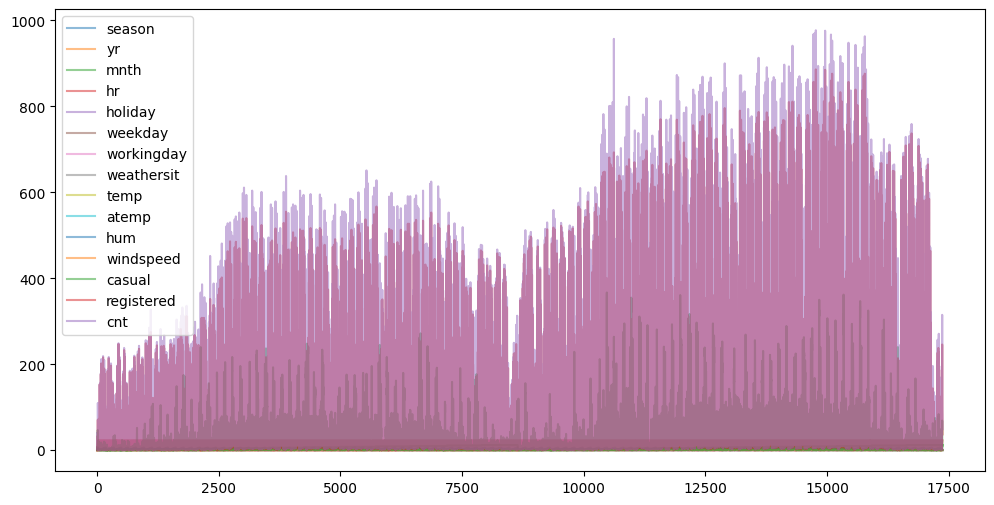

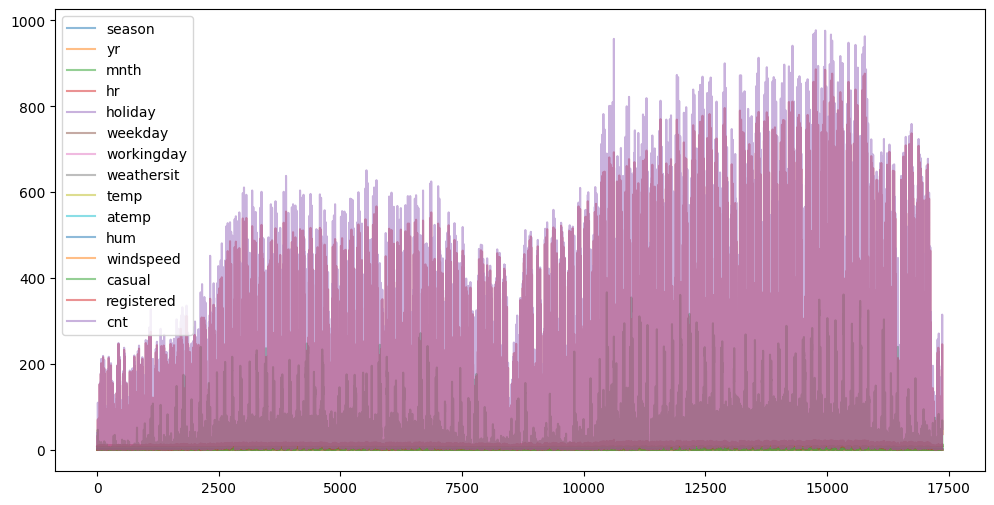

In [ ]:
# Reconstruct data using the first two principal components
reconstructed_data_hour = pca_hour.inverse_transform(pca_hour_result)
reconstructed_hour = pd.DataFrame(reconstructed_data_hour, columns=hour.columns, index=hour.index)

# Plotting original vs reconstructed data
hour.plot(figsize=(12, 6), alpha=0.5)
plt.show()
reconstructed_hour.plot(figsize=(12, 6), alpha=0.5)
plt.show()

In [ ]:
# X and y
# 1. Regression for cnt
# 2. Regression for casual
# 3. Regression for registered

# 1.
X1_day = reconstructed_day.drop(columns=['casual', 'registered', 'cnt'])
X1_hour = reconstructed_hour.drop(columns=['casual', 'registered', 'cnt'])

y1_day = reconstructed_day['cnt']
y1_hour = reconstructed_hour['cnt']

# 2.
X2_day = reconstructed_day.drop(columns=['casual', 'registered', 'cnt'])
X2_hour = reconstructed_hour.drop(columns=['casual', 'registered', 'cnt'])

y2_day = reconstructed_day['casual']
y2_hour = reconstructed_hour['casual']

# 3.
X3_day = reconstructed_day.drop(columns=['casual', 'registered', 'cnt'])
X3_hour = reconstructed_hour.drop(columns=['casual', 'registered', 'cnt'])

y3_day = reconstructed_day['registered']
y3_hour = reconstructed_hour['registered']

In [ ]:
# Splitting data
# 1. Regression for cnt
X1_train_day, X1_test_day, y1_train_day, y1_test_day = train_test_split(X1_day, y1_day, test_size=0.20, random_state=42)
X1_train_hour, X1_test_hour, y1_train_hour, y1_test_hour = train_test_split(X1_hour, y1_hour, test_size=0.20, random_state=42)

# 2. Regression for casual
X2_train_day, X2_test_day, y2_train_day, y2_test_day = train_test_split(X2_day, y2_day, test_size=0.20, random_state=42)
X2_train_hour, X2_test_hour, y2_train_hour, y2_test_hour = train_test_split(X2_hour, y2_hour, test_size=0.20, random_state=42)

# 3. Regression for registered
X3_train_day, X3_test_day, y3_train_day, y3_test_day = train_test_split(X3_day, y3_day, test_size=0.20, random_state=42)
X3_train_hour, X3_test_hour, y3_train_hour, y3_test_hour = train_test_split(X3_hour, y3_hour, test_size=0.20, random_state=42)

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
def xgboost_eval(dtest, dtrain, y_test, params, num_round):
  # Training the model
  bst = xgb.train(params, dtrain, num_round)

  # Predicting on the test set
  preds = bst.predict(dtest)

  # Evaluate the performance
  mse = mean_squared_error(y_test, preds)
  r2 = r2_score(y_test, preds)

  return bst, mse, r2


MSEs = []
r2s = []

# Set the parameters for XGBoost
# params = {
#     'max_depth': 3,  # the maximum depth of each tree
#     'eta': 0.3,      # the training step for each iteration
#     'objective': 'reg:squarederror',  # regression with squared loss
#     'eval_metric': 'logloss' # evaluation metric
# }


# Number of training iterations
num_round = 100

# Convert the dataset into an optimized data structure called Dmatrix
d1_train_day = xgb.DMatrix(X1_train_day, label=y1_train_day)
d1_test_day = xgb.DMatrix(X1_test_day, label=y1_test_day)
model_day_total, mse1_train_day, r2_1_train_day = xgboost_eval(d1_test_day, d1_train_day, y1_test_day, get_params(X1_train_day, y1_train_day), num_round)
MSEs.append(mse1_train_day)
r2s.append(r2_1_train_day)
print(f"MSE #1 (total count) for day: {mse1_train_day:.2f}")
print(f"R^2 Score #1 (total count) for day: {r2_1_train_day:.2f}")

# Convert the dataset into an optimized data structure called Dmatrix
d1_train_hour = xgb.DMatrix(X1_train_hour, label=y1_train_hour)
d1_test_hour = xgb.DMatrix(X1_test_hour, label=y1_test_hour)
model_hour_total, mse1_train_hour, r2_1_train_hour = xgboost_eval(d1_test_hour, d1_train_hour, y1_test_hour, get_params(X1_train_hour, y1_train_hour), num_round)
MSEs.append(mse1_train_hour)
r2s.append(r2_1_train_hour)
print(f"MSE #1 (total count) for hour: {mse1_train_hour:.2f}")
print(f"R^2 Score #1 (total count) for hour: {r2_1_train_hour:.2f}")

print('\n')

# Convert the dataset into an optimized data structure called Dmatrix
d2_train_day = xgb.DMatrix(X2_train_day, label=y2_train_day)
d2_test_day = xgb.DMatrix(X2_test_day, label=y2_test_day)
model_day_casual, mse2_train_day, r2_2_train_day = xgboost_eval(d2_test_day, d2_train_day, y2_test_day, get_params(X2_train_day, y2_train_day), num_round)
MSEs.append(mse2_train_day)
r2s.append(r2_2_train_day)
print(f"MSE #2 (casuals only) for day: {mse2_train_day:.2f}")
print(f"R^2 Score #2 (casuals only) for day: {r2_2_train_day:.2f}")

# Convert the dataset into an optimized data structure called Dmatrix
d2_train_hour = xgb.DMatrix(X2_train_hour, label=y2_train_hour)
d2_test_hour = xgb.DMatrix(X2_test_hour, label=y2_test_hour)
model_hour_casual, mse2_train_hour, r2_2_train_hour = xgboost_eval(d2_test_hour, d2_train_hour, y2_test_hour, get_params(X2_train_hour, y2_train_hour), num_round)
MSEs.append(mse2_train_hour)
r2s.append(r2_2_train_hour)
print(f"MSE #2 (casuals only) for hour: {mse2_train_hour:.2f}")
print(f"R^2 Score #2 (casuals only) for hour: {r2_2_train_hour:.2f}")

print('\n')

# Convert the dataset into an optimized data structure called Dmatrix
d3_train_day = xgb.DMatrix(X3_train_day, label=y3_train_day)
d3_test_day = xgb.DMatrix(X3_test_day, label=y3_test_day)
model_day_reg, mse3_train_day, r2_3_train_day = xgboost_eval(d3_test_day, d3_train_day, y3_test_day, get_params(X3_train_day, y3_train_day), num_round)
MSEs.append(mse3_train_day)
r2s.append(r2_3_train_day)
print(f"MSE #3 (registered only) for day: {mse3_train_day:.2f}")
print(f"R^2 Score #3 (registered only) for day: {r2_3_train_day:.2f}")

# Convert the dataset into an optimized data structure called Dmatrix
d3_train_hour = xgb.DMatrix(X3_train_hour, label=y3_train_hour)
d3_test_hour = xgb.DMatrix(X3_test_hour, label=y3_test_hour)
model_hour_reg, mse3_train_hour, r2_3_train_hour = xgboost_eval(d3_test_hour, d3_train_hour, y3_test_hour, get_params(X3_train_hour, y3_train_hour), num_round)
MSEs.append(mse3_train_hour)
r2s.append(r2_3_train_hour)
print(f"MSE #3 (registered only) for hour: {mse3_train_hour:.2f}")
print(f"R^2 Score #3 (registered only) for hour: {r2_3_train_hour:.2f}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
MSE #1 (total count) for day: 3938.70
R^2 Score #1 (total count) for day: 1.00
Fitting 3 folds for each of 108 candidates, totalling 324 fits
MSE #1 (total count) for hour: 2.76
R^2 Score #1 (total count) for hour: 1.00


Fitting 3 folds for each of 108 candidates, totalling 324 fits
MSE #2 (casuals only) for day: 1514.61
R^2 Score #2 (casuals only) for day: 1.00
Fitting 3 folds for each of 108 candidates, totalling 324 fits
MSE #2 (casuals only) for hour: 1.16
R^2 Score #2 (casuals only) for hour: 1.00


Fitting 3 folds for each of 108 candidates, totalling 324 fits
MSE #3 (registered only) for day: 1802.98
R^2 Score #3 (registered only) for day: 1.00
Fitting 3 folds for each of 108 candidates, totalling 324 fits
MSE #3 (registered only) for hour: 3.60
R^2 Score #3 (registered only) for hour: 1.00


[21:23:26] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


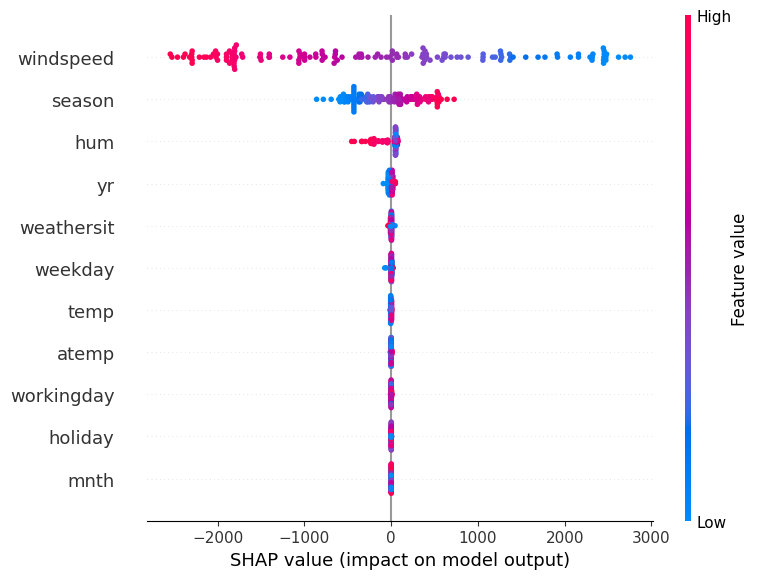

In [ ]:
# explain the predictions of day model for total ridership using SHAP
# X1_train_day100 = shap.utils.sample(X1_train_day, -1)
# X1_test_day50 = shap.utils.sample(X1_test_day, -1)
explainer = shap.TreeExplainer(model_day_total, X1_train_day)
shap_values = explainer.shap_values(X1_test_day)
shap.summary_plot(shap_values, X1_test_day)

[21:23:27] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 98%|===================| 3396/3476 [00:11<00:00]       

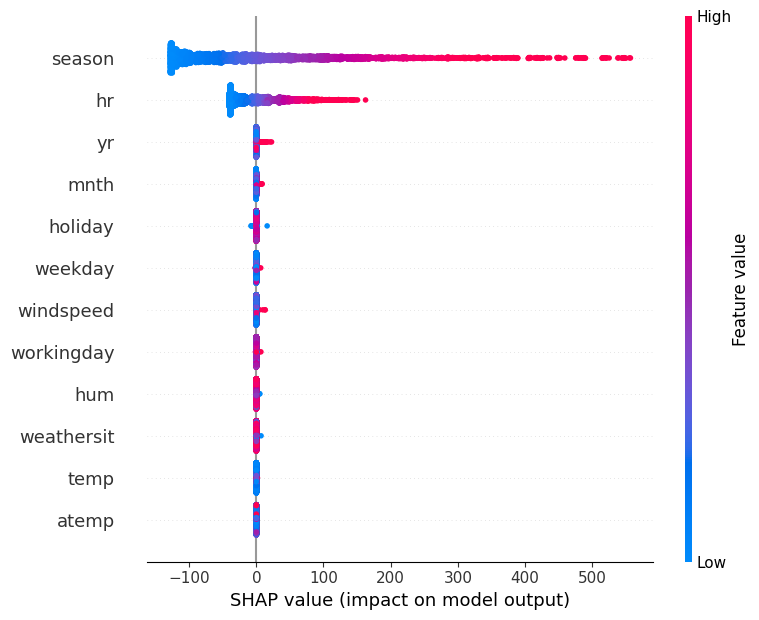

In [ ]:
# explain the predictions of day model for total ridership using SHAP
# X1_train_hour100 = shap.utils.sample(X1_train_hour, 100)
# X1_test_hour50 = shap.utils.sample(X1_test_hour, 50)
explainer = shap.TreeExplainer(model_hour_total, X1_train_hour)
shap_values = explainer.shap_values(X1_test_hour)
shap.summary_plot(shap_values, X1_test_hour)

[21:23:40] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


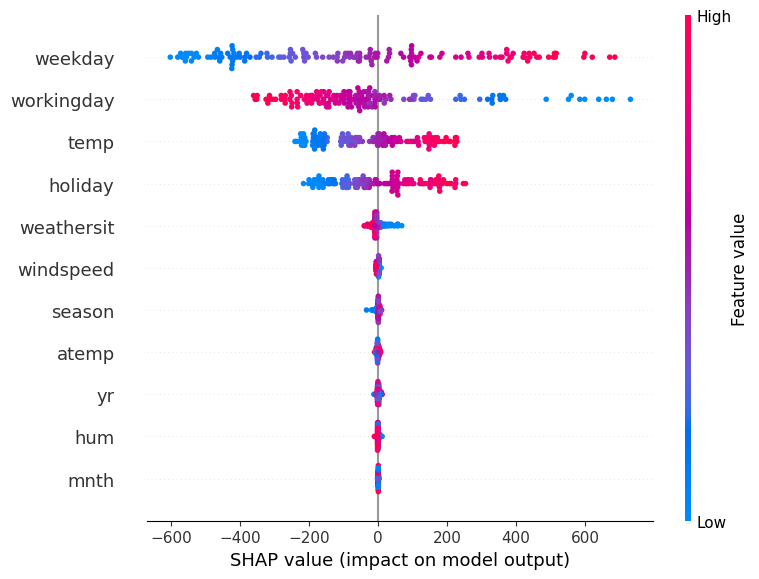

In [ ]:
# explain the predictions of day model for casual ridership using SHAP
# X2_train_day100 = shap.utils.sample(X2_train_day, 100)
# X2_test_day50 = shap.utils.sample(X2_test_day, 50)
explainer = shap.TreeExplainer(model_day_casual, X2_train_day)
shap_values = explainer.shap_values(X2_test_day)
shap.summary_plot(shap_values, X2_test_day)

[21:23:41] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


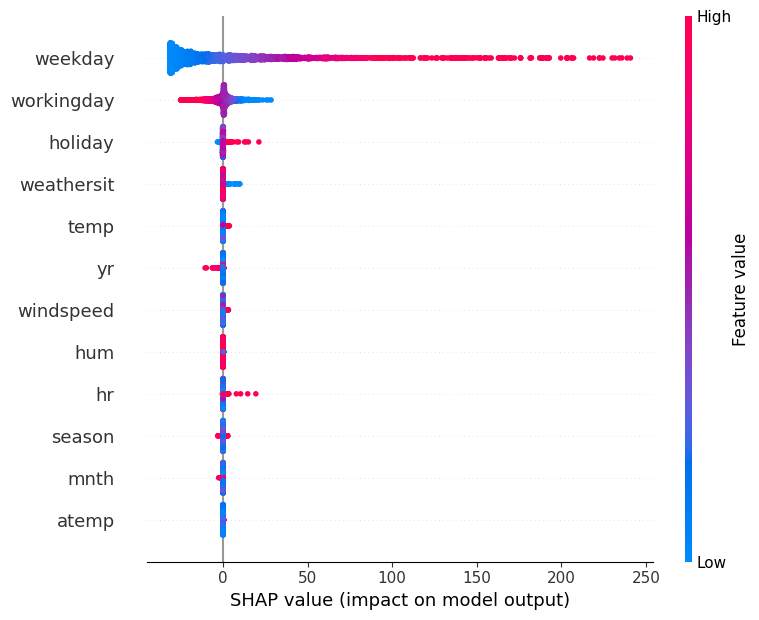

In [ ]:
# explain the predictions of day model for casual ridership using SHAP
# X2_train_hour100 = shap.utils.sample(X2_train_hour, 100)
# X2_test_hour50 = shap.utils.sample(X2_test_hour, 50)
explainer = shap.TreeExplainer(model_hour_casual, X2_train_hour)
shap_values = explainer.shap_values(X2_test_hour)
shap.summary_plot(shap_values, X2_test_hour)

[21:23:52] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


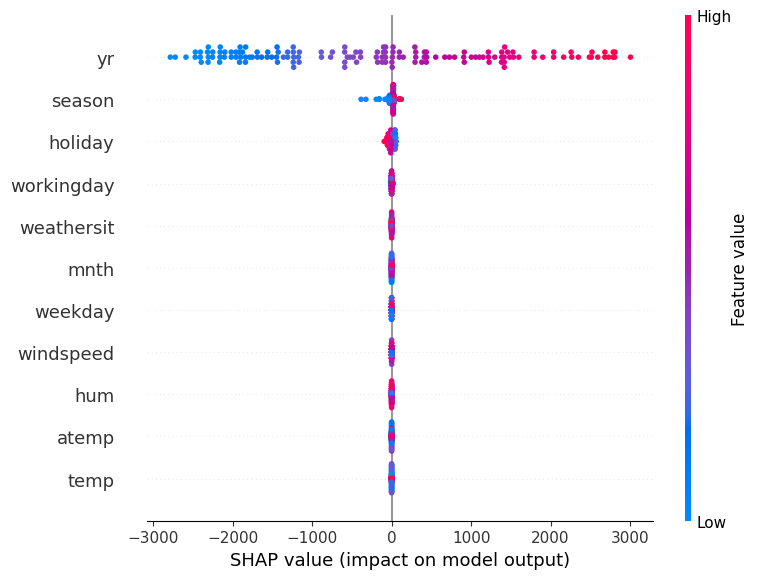

In [ ]:
# explain the predictions of day model for registered ridership using SHAP
# X3_train_day100 = shap.utils.sample(X3_train_day, 100)
# X3_test_day50 = shap.utils.sample(X3_test_day, 50)
explainer = shap.TreeExplainer(model_day_reg, X3_train_day)
shap_values = explainer.shap_values(X3_test_day)
shap.summary_plot(shap_values, X3_test_day)

[21:23:53] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 98%|===================| 3395/3476 [00:11<00:00]       

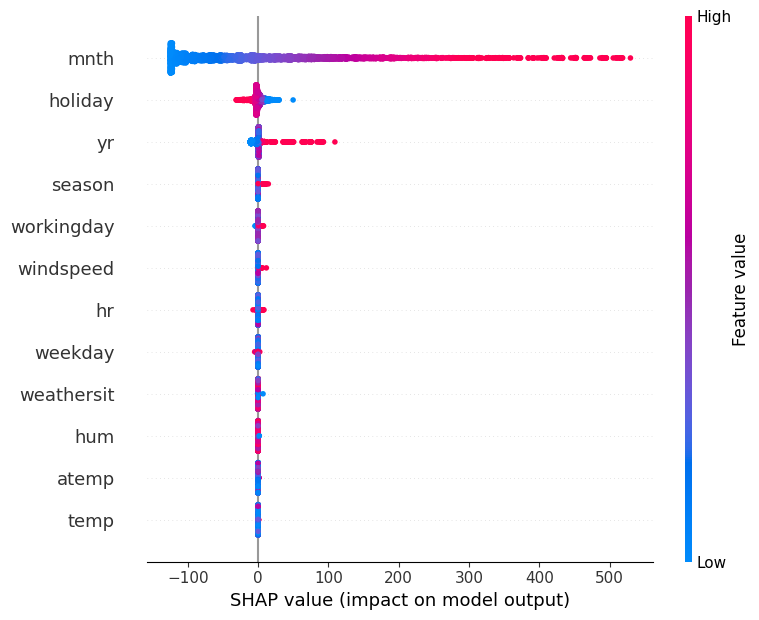

In [ ]:
# explain the predictions of day model for registered ridership using SHAP
# X3_train_hour100 = shap.utils.sample(X3_train_hour, 100)
# X3_test_hour50 = shap.utils.sample(X3_test_hour, 50)
explainer = shap.TreeExplainer(model_hour_reg, X3_train_hour)
shap_values = explainer.shap_values(X3_test_hour)
shap.summary_plot(shap_values, X3_test_hour)

# Random Forest

Model Training and Testing:

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

model = RandomForestRegressor()

MSEs = []
r2s = []

# train day total cnt
mse_1_day = -cross_val_score(model, X1_train_day, y1_train_day, cv=tscv, scoring='neg_mean_squared_error')
print('Average MSE for #1 (total count) for "day" df:', np.mean(mse_1_day))
r2_1_day = cross_val_score(model, X1_train_day, y1_train_day, cv=tscv, scoring='r2')
print('Average R2 for #1 (total count) for "day" df:', np.mean(r2_1_day))
print('\n')

# test day total cnt
model.fit(X1_train_day, y1_train_day)
y1_pred = model.predict(X1_test_day)
test_mse = mean_squared_error(y1_test_day, y1_pred)
print('Test MSE for #1 (total count) for "day" df:', test_mse)
test_r2 = r2_score(y1_test_day, y1_pred)
print('Test R2 for #1 (total count) for "day" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

# train hour total cnt
mse_1_hour = -cross_val_score(model, X1_train_hour, y1_train_hour, cv=tscv, scoring='neg_mean_squared_error')
print('Average MSE for #1 (total count) for "hour" df:', np.mean(mse_1_hour))
r2_1_hour = cross_val_score(model, X1_train_hour, y1_train_hour, cv=tscv, scoring='r2')
print('Average R2 for #1 (total count) for "hour" df:', np.mean(r2_1_hour))
print('\n')

# test hour total cnt
model.fit(X1_train_hour, y1_train_hour)
y1_pred = model.predict(X1_test_hour)
test_mse = mean_squared_error(y1_test_hour, y1_pred)
print('Test MSE for #1 (total count) for "hour" df:', test_mse)
test_r2 = r2_score(y1_test_hour, y1_pred)
print('Test R2 for #1 (total count) for "hour" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

# train day casual
mse_2_day = -cross_val_score(model, X2_train_day, y2_train_day, cv=tscv, scoring='neg_mean_squared_error')
print('Average MSE for #2 (casuals only) for "day" df:', np.mean(mse_1_day))
r2_2_day = cross_val_score(model, X2_train_day, y2_train_day, cv=tscv, scoring='r2')
print('Average R2 for #2 (casuals only) for "day" df:', np.mean(r2_2_day))
print('\n')

# test day casual
model.fit(X2_train_day, y2_train_day)
y2_pred = model.predict(X2_test_day)
test_mse = mean_squared_error(y2_test_day, y2_pred)
print('Test MSE for #2 (casuals only) for "day" df:', test_mse)
test_r2 = r2_score(y2_test_day, y2_pred)
print('Test R2 for #2 (casuals only) for "day" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

# train hour casual
mse_2_hour = -cross_val_score(model, X2_train_hour, y2_train_hour, cv=tscv, scoring='neg_mean_squared_error')
print('Average MSE for #2 (casuals only) for "hour" df:', np.mean(mse_2_hour))
r2_2_hour = cross_val_score(model, X2_train_hour, y2_train_hour, cv=tscv, scoring='r2')
print('Average R2 for #2 (casuals only) for "hour" df:', np.mean(r2_2_hour))
print('\n')

# test hour casual
model.fit(X2_train_hour, y2_train_hour)
y2_pred = model.predict(X2_test_hour)
test_mse = mean_squared_error(y2_test_hour, y2_pred)
print('Test MSE for #2 (casuals only) for "hour" df:', test_mse)
test_r2 = r2_score(y2_test_hour, y2_pred)
print('Test R2 for #2 (casuals only) for "hour" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

# train day registered
mse_3_day = -cross_val_score(model, X3_train_day, y3_train_day, cv=tscv, scoring='neg_mean_squared_error')
print('Average MSE for #3 (registered only) for "day" df:', np.mean(mse_3_day))
r2_3_day = cross_val_score(model, X3_train_day, y3_train_day, cv=tscv, scoring='r2')
print('Average R2 for #3 (registered only) for "day" df:', np.mean(r2_3_day))
print('\n')

# test day registered
model.fit(X3_train_day, y3_train_day)
y3_pred = model.predict(X3_test_day)
test_mse = mean_squared_error(y3_test_day, y3_pred)
print('Test MSE for #3 (registered only) for "day" df:', test_mse)
test_r2 = r2_score(y3_test_day, y3_pred)
print('Test R2 for #3 (registered only) for "day" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

# train hour registered
mse_3_hour = -cross_val_score(model, X3_train_hour, y3_train_hour, cv=tscv, scoring='neg_mean_squared_error')
print('Average MSE for #3 (registered only) for "hour" df:', np.mean(mse_3_hour))
r2_3_hour = cross_val_score(model, X3_train_hour, y3_train_hour, cv=tscv, scoring='r2')
print('Average R2 for #3 (registered only) for "hour" df:', np.mean(r2_3_hour))
print('\n')

# test hour registered
model.fit(X3_train_hour, y3_train_hour)
y3_pred = model.predict(X3_test_hour)
test_mse = mean_squared_error(y3_test_hour, y3_pred)
print('Test MSE for #3 (registered only) for "hour" df:', test_mse)
test_r2 = r2_score(y3_test_hour, y3_pred)
print('Test R2 for #3 (registered only) for "hour" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

Average MSE for #1 (total count) for "day" df: 635635.3254692784
Average R2 for #1 (total count) for "day" df: 0.8133565540425274


Test MSE for #1 (total count) for "day" df: 467804.8175435374
Test R2 for #1 (total count) for "day" df: 0.8833370199231472


Average MSE for #1 (total count) for "hour" df: 2573.605491359008
Average R2 for #1 (total count) for "hour" df: 0.9222160834420212


Test MSE for #1 (total count) for "hour" df: 1713.2387822966373
Test R2 for #1 (total count) for "hour" df: 0.9458955778564554


Average MSE for #2 (casuals only) for "day" df: 635635.3254692784
Average R2 for #2 (casuals only) for "day" df: 0.7495711634851062


Test MSE for #2 (casuals only) for "day" df: 73264.0573095238
Test R2 for #2 (casuals only) for "day" df: 0.8119522315893447


Average MSE for #2 (casuals only) for "hour" df: 273.4685512105038
Average R2 for #2 (casuals only) for "hour" df: 0.8870174265898745


Test MSE for #2 (casuals only) for "hour" df: 195.92280920611975
Test R2 for #2 (c

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

MSEs = []
r2s = []

model_day_total = RandomForestRegressor()

# train day total cnt
mse_1_day = -cross_val_score(model_day_total, X1_train_day, y1_train_day, cv=tscv, scoring='neg_mean_squared_error')
print('Average Training MSE for #1 (total count) for "day" df:', np.mean(mse_1_day))
r2_1_day = cross_val_score(model_day_total, X1_train_day, y1_train_day, cv=tscv, scoring='r2')
print('Average Training R2 for #1 (total count) for "day" df:', np.mean(r2_1_day))
print('\n')

# test day total cnt
model_day_total.fit(X1_train_day, y1_train_day)
y1_pred = model_day_total.predict(X1_test_day)
test_mse = mean_squared_error(y1_test_day, y1_pred)
print('Test MSE for #1 (total count) for "day" df:', test_mse)
test_r2 = r2_score(y1_test_day, y1_pred)
print('Test R2 for #1 (total count) for "day" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

model_hour_total = RandomForestRegressor()

# train hour total cnt
mse_1_hour = -cross_val_score(model_hour_total, X1_train_hour, y1_train_hour, cv=tscv, scoring='neg_mean_squared_error')
print('Average Training MSE for #1 (total count) for "hour" df:', np.mean(mse_1_hour))
r2_1_hour = cross_val_score(model_hour_total, X1_train_hour, y1_train_hour, cv=tscv, scoring='r2')
print('Average Training R2 for #1 (total count) for "hour" df:', np.mean(r2_1_hour))
print('\n')

# test hour total cnt
model_hour_total.fit(X1_train_hour, y1_train_hour)
y1_pred = model_hour_total.predict(X1_test_hour)
test_mse = mean_squared_error(y1_test_hour, y1_pred)
print('Test MSE for #1 (total count) for "hour" df:', test_mse)
test_r2 = r2_score(y1_test_hour, y1_pred)
print('Test R2 for #1 (total count) for "hour" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

model_day_casual = RandomForestRegressor()

# train day casual
mse_2_day = -cross_val_score(model_day_casual, X2_train_day, y2_train_day, cv=tscv, scoring='neg_mean_squared_error')
print('Average Training MSE for #2 (casuals only) for "day" df:', np.mean(mse_1_day))
r2_2_day = cross_val_score(model_day_casual, X2_train_day, y2_train_day, cv=tscv, scoring='r2')
print('Average Training R2 for #2 (casuals only) for "day" df:', np.mean(r2_2_day))
print('\n')

# test day casual
model_day_casual.fit(X2_train_day, y2_train_day)
y2_pred = model_day_casual.predict(X2_test_day)
test_mse = mean_squared_error(y2_test_day, y2_pred)
print('Test MSE for #2 (casuals only) for "day" df:', test_mse)
test_r2 = r2_score(y2_test_day, y2_pred)
print('Test R2 for #2 (casuals only) for "day" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

model_hour_casual = RandomForestRegressor()

# train hour casual
mse_2_hour = -cross_val_score(model_hour_casual, X2_train_hour, y2_train_hour, cv=tscv, scoring='neg_mean_squared_error')
print('Average Training MSE for #2 (casuals only) for "hour" df:', np.mean(mse_2_hour))
r2_2_hour = cross_val_score(model_hour_casual, X2_train_hour, y2_train_hour, cv=tscv, scoring='r2')
print('Average Training R2 for #2 (casuals only) for "hour" df:', np.mean(r2_2_hour))
print('\n')

# test hour casual
model_hour_casual.fit(X2_train_hour, y2_train_hour)
y2_pred = model_hour_casual.predict(X2_test_hour)
test_mse = mean_squared_error(y2_test_hour, y2_pred)
print('Test MSE for #2 (casuals only) for "hour" df:', test_mse)
test_r2 = r2_score(y2_test_hour, y2_pred)
print('Test R2 for #2 (casuals only) for "hour" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

model_day_reg = RandomForestRegressor()

# train day registered
mse_3_day = -cross_val_score(model_day_reg, X3_train_day, y3_train_day, cv=tscv, scoring='neg_mean_squared_error')
print('Average MSE for #3 (registered only) for "day" df:', np.mean(mse_3_day))
r2_3_day = cross_val_score(model_day_reg, X3_train_day, y3_train_day, cv=tscv, scoring='r2')
print('Average R2 for #3 (registered only) for "day" df:', np.mean(r2_3_day))
print('\n')

# test day registered
model_day_reg.fit(X3_train_day, y3_train_day)
y3_pred = model_day_reg.predict(X3_test_day)
test_mse = mean_squared_error(y3_test_day, y3_pred)
print('Test MSE for #3 (registered only) for "day" df:', test_mse)
test_r2 = r2_score(y3_test_day, y3_pred)
print('Test R2 for #3 (registered only) for "day" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

model_hour_reg = RandomForestRegressor()

# train hour registered
mse_3_hour = -cross_val_score(model_hour_reg, X3_train_hour, y3_train_hour, cv=tscv, scoring='neg_mean_squared_error')
print('Average Training MSE for #3 (registered only) for "hour" df:', np.mean(mse_3_hour))
r2_3_hour = cross_val_score(model_hour_reg, X3_train_hour, y3_train_hour, cv=tscv, scoring='r2')
print('Average Training R2 for #3 (registered only) for "hour" df:', np.mean(r2_3_hour))
print('\n')

# test hour registered
model_hour_reg.fit(X3_train_hour, y3_train_hour)
y3_pred = model_hour_reg.predict(X3_test_hour)
test_mse = mean_squared_error(y3_test_hour, y3_pred)
print('Test MSE for #3 (registered only) for "hour" df:', test_mse)
test_r2 = r2_score(y3_test_hour, y3_pred)
print('Test R2 for #3 (registered only) for "hour" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

Average Training MSE for #1 (total count) for "day" df: 629548.9910672165
Average Training R2 for #1 (total count) for "day" df: 0.8180690191747642


Test MSE for #1 (total count) for "day" df: 450767.8045503401
Test R2 for #1 (total count) for "day" df: 0.887585776312257


Average Training MSE for #1 (total count) for "hour" df: 2593.2337734671296
Average Training R2 for #1 (total count) for "hour" df: 0.9217115182495469


Test MSE for #1 (total count) for "hour" df: 1765.0467115242695
Test R2 for #1 (total count) for "hour" df: 0.9442594731276346


Average Training MSE for #2 (casuals only) for "day" df: 629548.9910672165
Average Training R2 for #2 (casuals only) for "day" df: 0.7426791594051447


Test MSE for #2 (casuals only) for "day" df: 73923.17515986394
Test R2 for #2 (casuals only) for "day" df: 0.8102604655934698


Average Training MSE for #2 (casuals only) for "hour" df: 272.51602101385436
Average Training R2 for #2 (casuals only) for "hour" df: 0.8865155596413276


Test MSE

  0%|          | 0/50 [00:00<?, ?it/s]

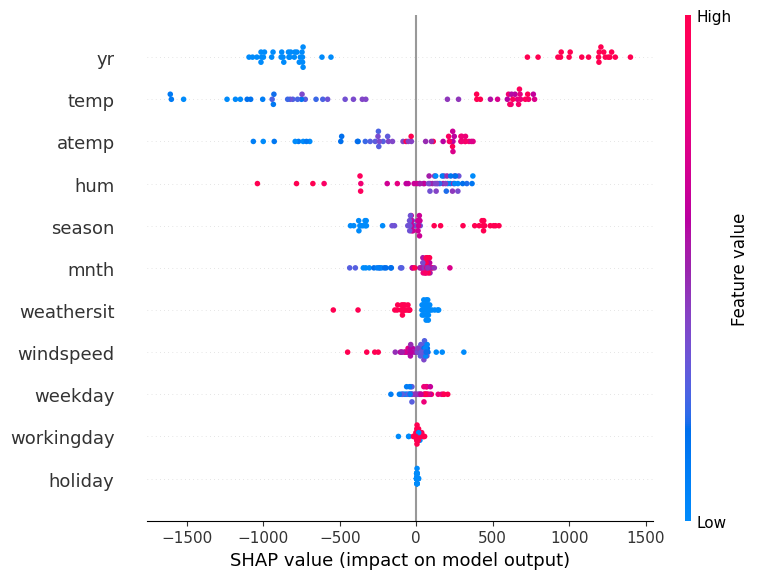

In [ ]:
# explain the predictions of day model for total ridership using SHAP
X1_train_day100 = shap.utils.sample(X1_train_day, 100)
X1_test_day50 = shap.utils.sample(X1_test_day, 50)
explainer = shap.KernelExplainer(model_day_total.predict, X1_train_day100)
shap_values = explainer.shap_values(X1_test_day50)
shap.summary_plot(shap_values, X1_test_day50)

  0%|          | 0/50 [00:00<?, ?it/s]

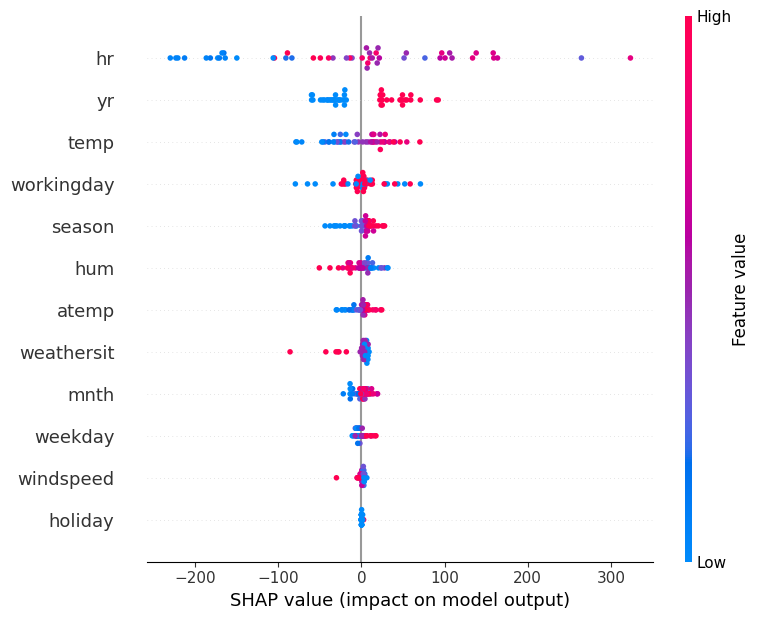

In [ ]:
# explain the predictions of day model for total ridership using SHAP
X1_train_hour100 = shap.utils.sample(X1_train_hour, 100)
X1_test_hour50 = shap.utils.sample(X1_test_hour, 50)
explainer = shap.KernelExplainer(model_hour_total.predict, X1_train_hour100)
shap_values = explainer.shap_values(X1_test_hour50)
shap.summary_plot(shap_values, X1_test_hour50)

  0%|          | 0/50 [00:00<?, ?it/s]

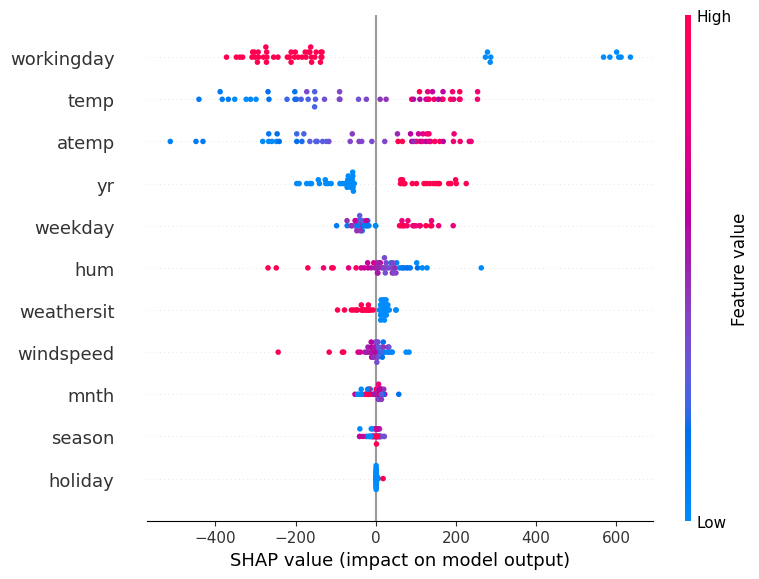

In [ ]:
# explain the predictions of day model for casual ridership using SHAP
X2_train_day100 = shap.utils.sample(X2_train_day, 100)
X2_test_day50 = shap.utils.sample(X2_test_day, 50)
explainer = shap.KernelExplainer(model_day_casual.predict, X2_train_day100)
shap_values = explainer.shap_values(X2_test_day50)
shap.summary_plot(shap_values, X2_test_day50)

  0%|          | 0/50 [00:00<?, ?it/s]

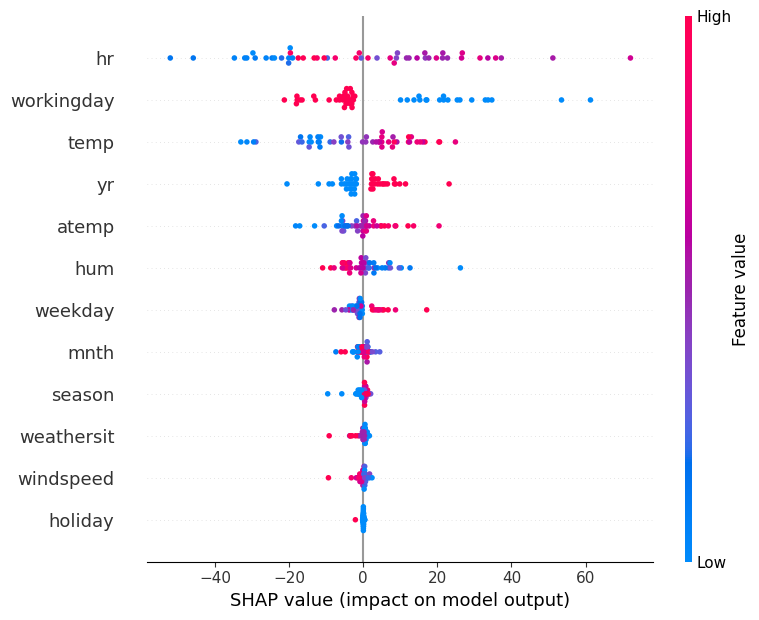

In [ ]:
# explain the predictions of day model for casual ridership using SHAP
X2_train_hour100 = shap.utils.sample(X2_train_hour, 100)
X2_test_hour50 = shap.utils.sample(X2_test_hour, 50)
explainer = shap.KernelExplainer(model_hour_casual.predict, X2_train_hour100)
shap_values = explainer.shap_values(X2_test_hour50)
shap.summary_plot(shap_values, X2_test_hour50)

  0%|          | 0/50 [00:00<?, ?it/s]

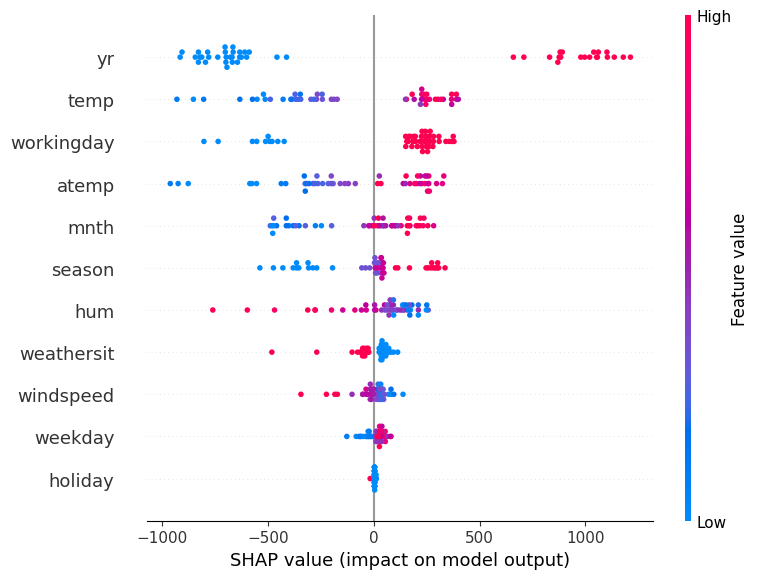

In [ ]:
# explain the predictions of day model for registered ridership using SHAP
X3_train_day100 = shap.utils.sample(X3_train_day, 100)
X3_test_day50 = shap.utils.sample(X3_test_day, 50)
explainer = shap.KernelExplainer(model_day_reg.predict, X3_train_day100)
shap_values = explainer.shap_values(X3_test_day50)
shap.summary_plot(shap_values, X3_test_day50)

  0%|          | 0/50 [00:00<?, ?it/s]

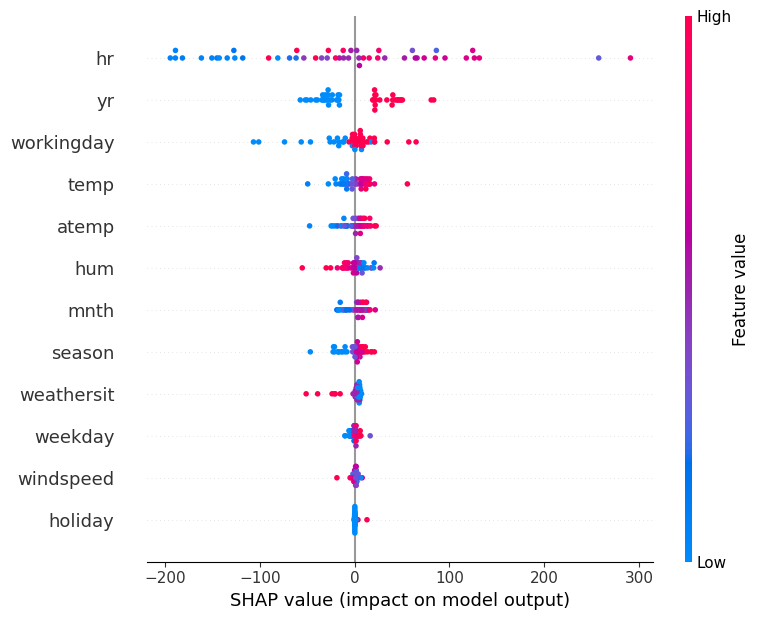

In [ ]:
# explain the predictions of day model for registered ridership using SHAP
X3_train_hour100 = shap.utils.sample(X3_train_hour, 100)
X3_test_hour50 = shap.utils.sample(X3_test_hour, 50)
explainer = shap.KernelExplainer(model_hour_reg.predict, X3_train_hour100)
shap_values = explainer.shap_values(X3_test_hour50)
shap.summary_plot(shap_values, X3_test_hour50)

Text(0.5, 1.0, 'Mean Squared Error for Hourly Dataset')

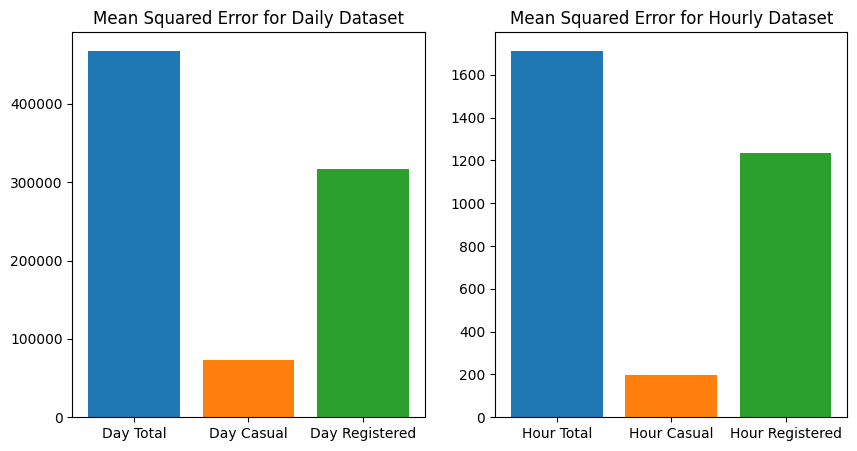

In [ ]:

labels = ['Day Total', 'Hour Total',
          'Day Casual', 'Hour Casual',
          'Day Registered', 'Hour Registered']
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

for i, j in zip(labels, MSEs):
  if 'Day' in i:
    ax1.bar(i, j)
  else:
    ax2.bar(i, j)

ax1.set_title('Mean Squared Error for Daily Dataset')

ax2.set_title('Mean Squared Error for Hourly Dataset')



Text(0.5, 1.0, 'R2 Score for Hourly Dataset')

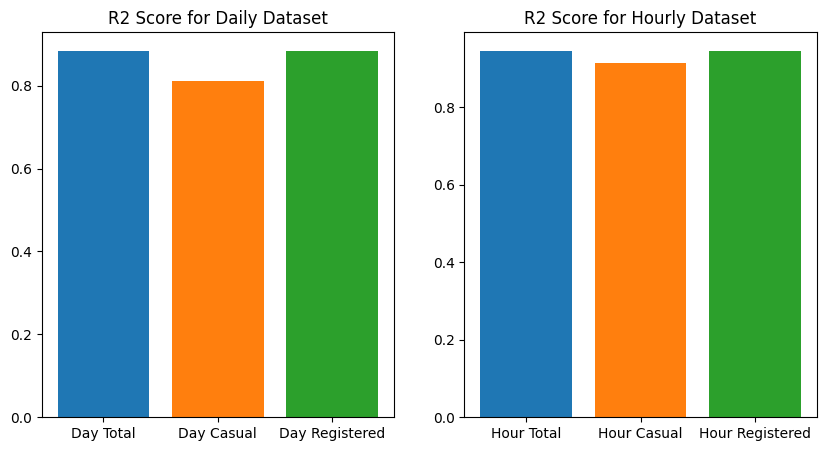

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

for i, j in zip(labels, r2s):
  if 'Day' in i:
    ax1.bar(i, j)
  else:
    ax2.bar(i, j)

ax1.set_title('R2 Score for Daily Dataset')
ax2.set_title('R2 Score for Hourly Dataset')



(3476,)
(3476,)


Text(0.5, 1.0, 'Actual vs Predicted for Hourly Registered Dataset')

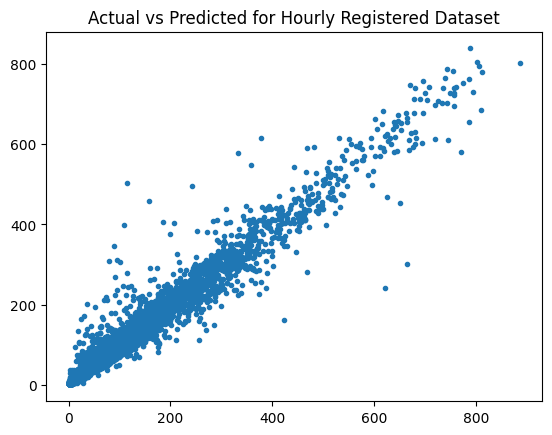

In [ ]:
# graphical output for last model Hourly Registered
print(y3_pred.shape)
print(y3_test_hour.shape)
plt.plot(y3_test_hour, y3_pred, '.')
plt.title('Actual vs Predicted for Hourly Registered Dataset')
# plt.plot(y3_test_hour, '.')